# Final Project Explainer Notebook 

### 02805 Social Graph and Interactions DTU 2022

##### This project was created by Ziwei Chen, Eleftherios Katiforis, Spyridon Vlachospyros


## An investigation on Rick & Morty series


In this notebook we are going to present our investigation and results on the analysis of the Rick & Morty series. To start with we presented our initial goals and ideas in a two minutes video. After that the actual analysis and finding are presented.

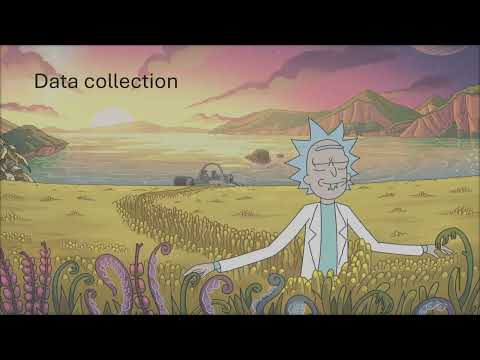

In [23]:
# link: https://www.youtube.com/watch?v=D2lKDo24Sv8&ab_channel=Zoi_Chen
from IPython.display import YouTubeVideo
YouTubeVideo("D2lKDo24Sv8",width=800, height=450)

## Table of contents
- [Introduction](#Introduction)
- [Data collection and preprocessing](#Data-collection-and-preprocessing)
- [Graph Analysis](#Graph-Analysis)
- [Communities](#Communities)
- [Centrality](#Centrality) 
- [Sentiment Analysis](#Sentiment-Analysis)

## Introduction


As we have allready mention we will focus on the Rick & Morty universe. We found intrest to these series because Of appealing it is to the audience and because of the multiuniverse it has create around the characters. Humans, alliens, creatures from different planets and universis are perform together in a dark and humoristic episodes. To do this analyis we will need access to some data. Lucky for us we were able to use a variety of sources that we are going to include in the following analysis. First of all, data regarding the characters like their name, species, locations and more were provided in the Rick & Morti [wiki](https://rickandmorty.fandom.com/wiki/Rickipedia). Our second source was the [imdb](https://www.imdb.com/search/title/?series=tt2861424&sort=user_rating,desc&count=250&view=advanced) page of the series where we were able to extract data like the ratings. Last but not least we also gother data about the transcripts of the episode from a [dataset](https://www.kaggle.com/datasets/andradaolteanu/rickmorty-scripts).

## Data collection and preprocessing

Since the notebook whould be too long we didnt include here all the code of just collecting the data or creating the graph. All the other code is available on our github repository or just by following the liks.
* Graph creation [link](https://github.com/lefteriskat/SocialGraphsAndInteractions2022/blob/main/Project/Code/Graph_Creation.ipynb)
* IMDB dataset and ratings [link](https://github.com/lefteriskat/SocialGraphsAndInteractions2022/blob/main/Project/Data/IMDB_ratings_parser.ipynb)
* Episodes data extraction [link](https://github.com/lefteriskat/SocialGraphsAndInteractions2022/blob/main/Project/Data/episode_Data_extraction.ipynb)

We start our assignment with loading all the nessesary imports we are going to need. Followed that we have some deffinitions as well as some helpful functions that we are going to use.

In [1]:
################## imports  ####################################
import urllib.request
import pandas as pd
import json
import os
from tqdm.notebook import tqdm
import networkx as nx
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from networkx.algorithms.community.centrality import girvan_newman
from networkx.algorithms.community.kclique import k_clique_communities
from networkx.algorithms.community.centrality import girvan_newman
from matplotlib.axes._axes import _log as matplotlib_axes_logger
import community
from matplotlib.lines import Line2D
from fa2 import ForceAtlas2
import warnings
import urllib.request
import json
from scipy import stats
import os
import json
from bs4 import BeautifulSoup
import nltk
from nltk.tokenize import RegexpTokenizer
from matplotlib.lines import Line2D
import ast
import pprint
from wordcloud import WordCloud, ImageColorGenerator 
from PIL import Image 
from stop_words import get_stop_words
from nltk.corpus import stopwords
import pprint
from nltk import word_tokenize
import string
import csv
import operator
import numpy.random
import statistics
import ast
import math
from collections import Counter
from community import community_louvain
import itertools
import colorcet as cc
from sklearn.datasets import make_blobs
import random
warnings.filterwarnings("ignore")
matplotlib_axes_logger.setLevel('ERROR')

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [25]:
#################### Functions ################################
def flatten_and_remove_empty(l):
    return [item for sublist in l for item in sublist if item != '']

### Just Read From Pickle

In [33]:
df = pd.read_pickle("../Data/characters.pickle")
df.shape

(289, 6)

In [34]:
# Initializing
G = nx.DiGraph()

for ind in df.index:
    name = df['Name'][ind]
    species = df['Species'][ind]
    status = df['Status'][ind]
    lastKnownLocation = df['LastKnownLocation'][ind]
    imgUrl = df['ImageUrl'][ind]
    wikiText = str(df["Wikitext"][ind])
    valid_links = []
    
    # Creating Node
    G.add_node(name, Species = species, Status = status, LastKnownLocation = lastKnownLocation)

for ind in df.index:
    name = df['Name'][ind]
    species = df['Species'][ind]
    status = df['Status'][ind]
    lastKnownLocation = df['LastKnownLocation'][ind]
    imgUrl = df['ImageUrl'][ind]
    wikiText = str(df["Wikitext"][ind])
    valid_links = []
    # Getting links & infos
    #links = re.findall(r'\[\[([\w\-_\#(\)\s]+)\|?([\w\-\s#\(\)]*)\]\]', wikiText)
    links = re.findall(r"\[\[(.*?)\]\]", wikiText)
    #links = flatten_and_remove_empty(links)
    # Creating Node
    G.add_node(name, Species = species, Status = status, LastKnownLocation = lastKnownLocation)
    valid_character_names = list(df["Name"])
    valid_character_names2 = [name.replace(" ","").lower() for name in valid_character_names]
    # Sorting links
    # For each link we check if it contains any name in the characters name list
    for link in links:
        if link == 'Rick':
            link = 'Rick Sanchez'
        if link == 'Morty':
            link = 'Morty Smith'
        for l_name in valid_character_names:
            if (l_name != name) and (l_name in link) and ('Category:' not in link) and ('Image:' not in link) and (l_name not in valid_links):
                valid_links.append(l_name)
                G.add_edge(name, l_name)
                
            name2  = name.replace(" ","").lower()
            link2 = link.replace(" ","").lower()
            l_name2 = l_name.replace(" ","").lower()
            
            if (l_name2 != name2) and (l_name2 in link2) and ('category:' not in link2) and ('image:' not in link2) and (l_name2 not in valid_links):
                valid_links.append(l_name2)
                G.add_edge(name, l_name)
            
            
            
print(nx.info(G))

DiGraph with 289 nodes and 889 edges


In [35]:
nx.write_gpickle(G, "../Data/final_graph.gpickle")

## Graph Analysis

In this chapter our initial graph analysis will start. We will try to show some basic statistics from the graph including :
* Some plots from our data collections
* The number of nodes and links of the graph.
* The average, median, mode, minimum and maximum value of the network's in-degree.s
* The out-degrees.
* A degree distribution plot

In [46]:
#Original dataset with our characters
df = pd.read_pickle("../Data/characters.pickle")
G_un = G.to_directed()

In [37]:
df.head()

Name Species Status  \
0      Rick Sanchez   Human  Alive   
1       Morty Smith   Human  Alive   
2      Summer Smith   Human  Alive   
3        Beth Smith   Human  Alive   
4  Adjudicator Rick   Human   Dead   

                                            ImageUrl  \
0  https://rickandmortyapi.com/api/character/avat...   
1  https://rickandmortyapi.com/api/character/avat...   
2  https://rickandmortyapi.com/api/character/avat...   
3  https://rickandmortyapi.com/api/character/avat...   
4  https://rickandmortyapi.com/api/character/avat...   

                                   LastKnownLocation  \
0  {'name': 'Citadel of Ricks', 'url': 'https://r...   
1  {'name': 'Citadel of Ricks', 'url': 'https://r...   
2  {'name': 'Earth (Replacement Dimension)', 'url...   
3  {'name': 'Earth (Replacement Dimension)', 'url...   
4  {'name': 'Citadel of Ricks', 'url': 'https://r...   

                                            Wikitext  
0  b'{{SimilarName|Rick Sanchez (C-137)|[[Rick (d...  
1  b'{{SimilarName|the main character we follow t...  
2  b'{{for|other versions of Summer Smith|Summer ...  
3  b'{{Character\n|name = Beth Smith\n|image = Be...  
4  b"{{Character|image = AdjudicatorRick.PNG|spec...

In [38]:
df.Species.value_counts()

Human                    136
Alien                     84
Humanoid                  24
Mythological Creature     19
Robot                      7
Cronenberg                 6
Poopybutthole              5
unknown                    4
Animal                     4
Name: Species, dtype: int64

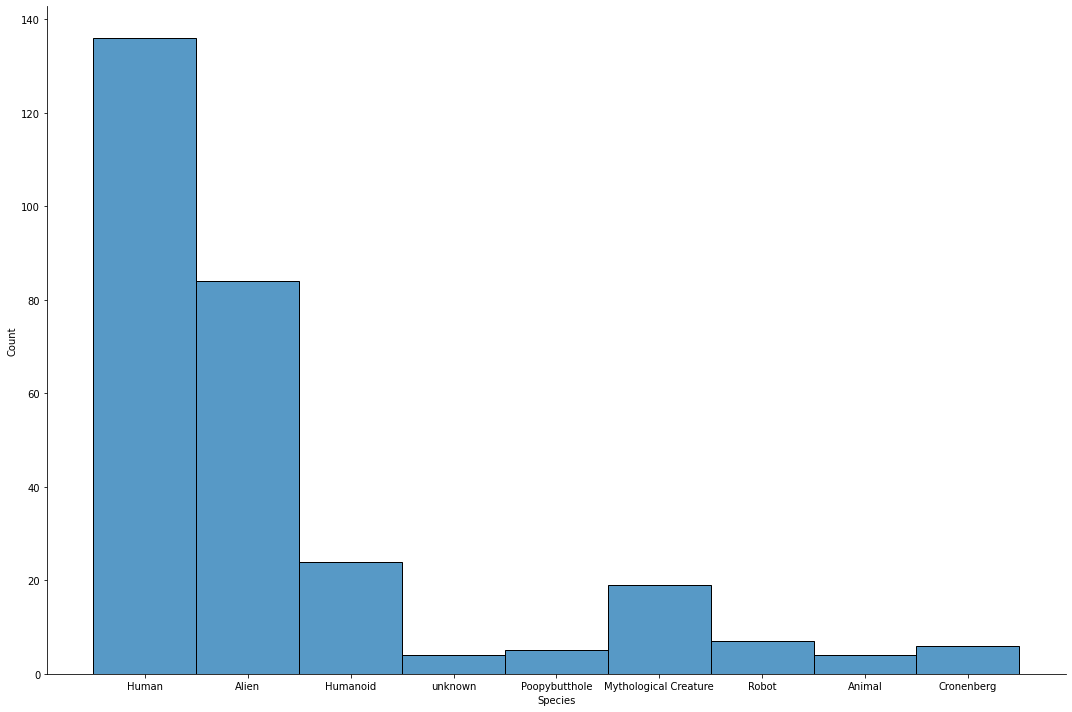

In [39]:
sns.displot(df,x='Species',height=10, aspect=1.5)

As we probably mentioned earlier this show consist of different kind of characters. In this plot here we can easily see that we have 9 different kind of species. Most of the characters are human with aliens and humanoids following. In total we have 288 characters involing our analysis.

In [40]:
df.Status.value_counts()

Alive      137
Dead       107
unknown     45
Name: Status, dtype: int64

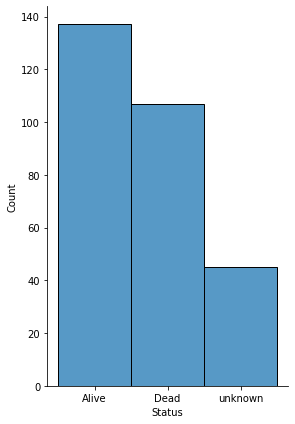

In [41]:
sns.displot(df,x='Status',height=6, aspect=.7)

Another intresting fact is that almost half of them end up being killed through the episodes, well in more than 40 cases we dont really know what happent to the character.

In [42]:
df.LastKnownLocation.str['name'].value_counts()

Earth (Replacement Dimension)                 72
Citadel of Ricks                              45
Interdimensional Cable                        37
Earth (C-137)                                 18
unknown                                       12
Nuptia 4                                       9
Post-Apocalyptic Earth                         8
Worldender's lair                              7
Unity's Planet                                 6
Planet Squanch                                 5
Anatomy Park                                   5
Mr. Goldenfold's dream                         5
Rick's Memories                                5
Purge Planet                                   4
St. Gloopy Noops Hospital                      4
Resort Planet                                  4
Zigerion's Base                                4
Earth (C-500A)                                 3
Dorian 5                                       3
Immortality Field Resort                       3
Heist-Con           

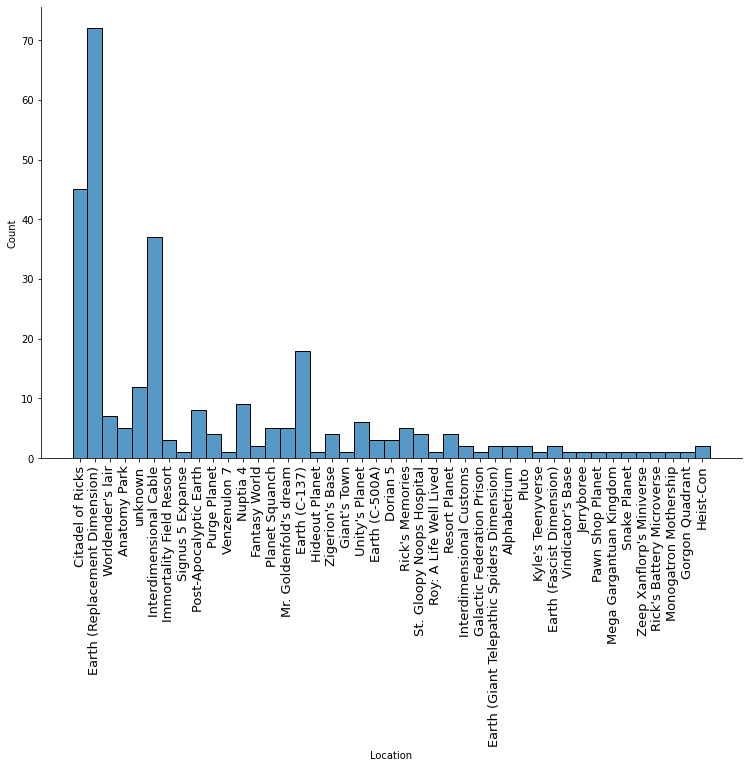

In [43]:
df['Location'] = df.LastKnownLocation.str['name'] #.value_counts()
sns.displot(df,x='Location',height=7, aspect=1.5)
plt.xticks(rotation=90, size=13)
plt.show()

Another intresting think that we mention and it also depicts to the data are all the different areas, planets and universes that the series taken place to. 

In [47]:
print("The Graph consists of ",G.number_of_nodes() ,"nodes and ",G.number_of_edges(),"edges")

The Graph consists of  289 nodes and  889 edges


In [117]:
in_degrees = sorted(list(G.in_degree()),key=lambda d: d[1], reverse=True)
out_degrees = sorted(list(G.out_degree()),key=lambda d: d[1], reverse=True)

in_only_degrees = [val for node,val in in_degrees]
out_only_degrees = [val for node,val in out_degrees]

#for the whole network
print("5 most connceted heroes in the whole network based on incoming degree")
print(in_degrees[:5])
print("5 most connceted heroes in the whole network based on outgoing degree")
print(out_degrees[:5])

5 most connceted heroes in the whole network based on incoming degree
[('Rick Sanchez', 149), ('Morty Smith', 131), ('Summer Smith', 36), ('Beth Smith', 33), ('Worldender', 16)]
5 most connceted heroes in the whole network based on outgoing degree
[('Morty Smith', 27), ('Rick Sanchez', 22), ('Summer Smith', 16), ('Beth Smith', 14), ('Hemorrhage', 13)]


Here we have our first ouputs from the Graph. The graph consists of 288 nodes and 877 edges the avverage shorter path of the network is 2.3 and one of the first worth noticed outcomes are the incoming degree of the Worldender which is 16 placing him 5th on the five most connceted heroes. The Worldender is a supervillain and he only appeared in one episode. One of the reason that this character is 5th on the least might be tha fact that he was the nemesis os the Vindicators a supers hero team made in the series consisting of 11 characters. So despite the fact that he was only present in one episode he was connected with a lot of the characters including the main ones.  

100%|██████████| 2000/2000 [00:07<00:00, 268.75it/s]


BarnesHut Approximation  took  0.92  seconds
Repulsion forces  took  6.12  seconds
Gravitational forces  took  0.04  seconds
Attraction forces  took  0.02  seconds
AdjustSpeedAndApplyForces step  took  0.17  seconds


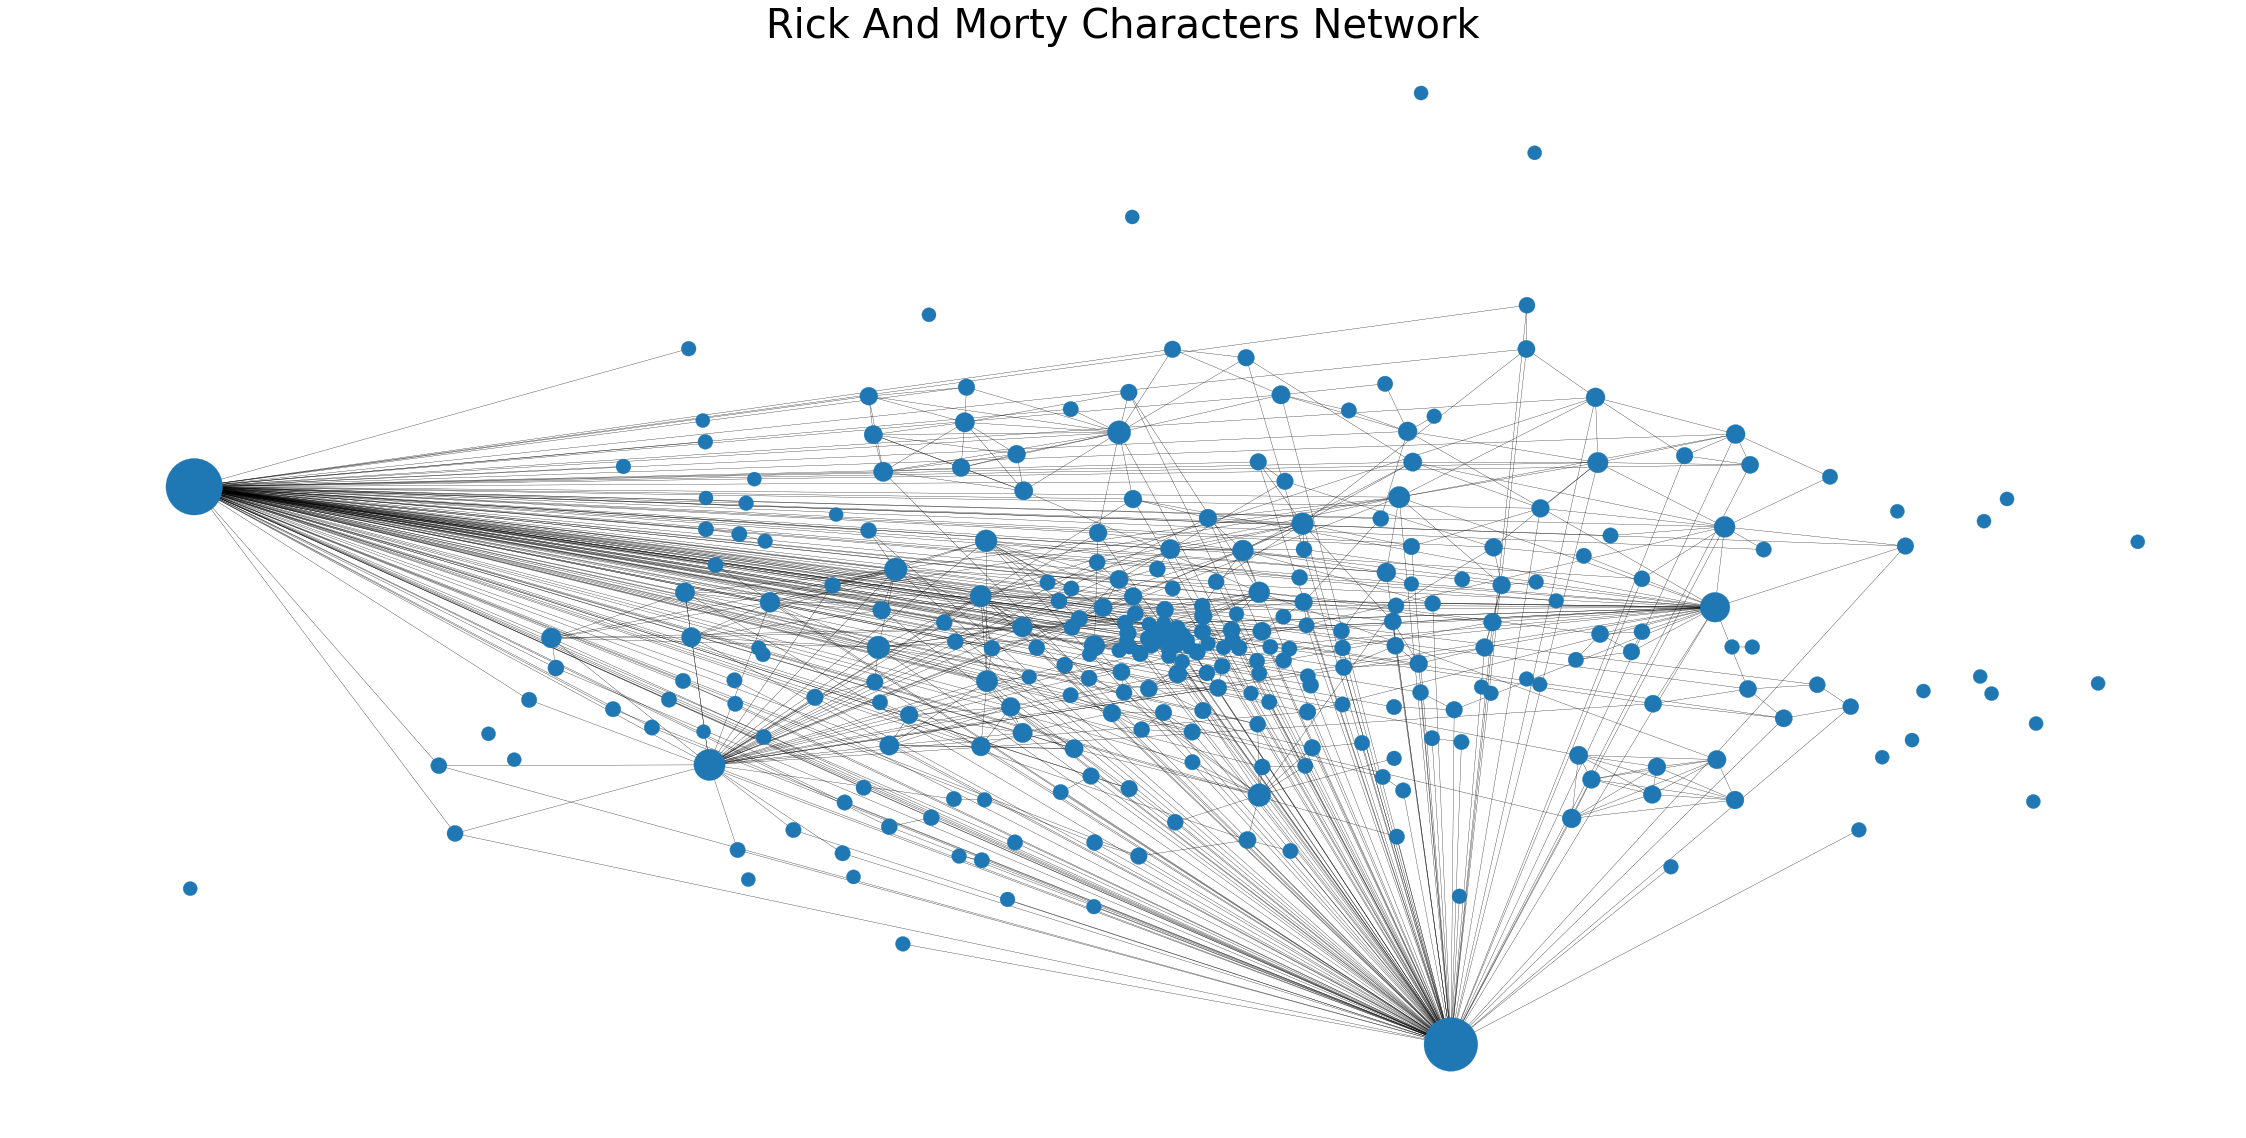

In [54]:
G_un = G.to_undirected()
node_sizes = [val*20+200 for node, val in G_un.degree()]
# node_colors = ['#0000CD' if node[1]['universe'] == "DC" else '#B22222' for node in WCC_undirected.nodes(data=True)]
# edge_colors = ['#000080' if WCC_undirected.nodes[node1]['universe'] == WCC_undirected.nodes[node2]['universe'] == "DC"\
#                else '#8B0000' if WCC_undirected.nodes[node1]['universe'] == WCC_undirected.nodes[node2]['universe'] == "Marvel" \
#                else '#8B008B' for node1,node2 in WCC_undirected.edges]

forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=True,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=0,

                        # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.0,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=0.1,
                        strongGravityMode=False,
                        gravity=7,

                        # Log
                        verbose=True)

# plt.figure(figsize=(25,25))
# ax = plt.gca()
# ax.set_title('DC-Marvel Characters Network',fontsize = 40) 
args = {
#'node_color': node_colors,
#'edge_color':edge_colors,
'node_size':node_sizes,
'width':0.3,
'linewidths':0.3,
}

figure = plt.figure(figsize=(40,20))
# plt.savefig(figure, dpi=1200)
ax = plt.gca()
ax.set_title('Rick And Morty Characters Network',fontsize = 40) 

positions = forceatlas2.forceatlas2_networkx_layout(G_un, pos=None, iterations=2000)
nx.draw(G_un,positions, **args, ax=ax)

plt.show()

Text(0.5, 1.0, 'Circular plot of our Graph')

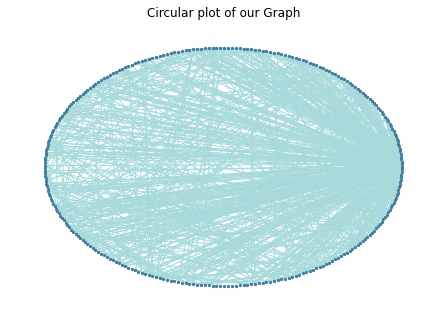

In [55]:
nx.draw_circular(G_un, node_size=5, node_color='#457B9D',edge_color= '#A8DADC')
plt.title('Circular plot of our Graph')

As it was expected the graph representation is created around our main characters. This is a tendency that happens in most of the series, episodes or colection of movies because everything is happening arround the main characters. Espacially in Rick & Morty we have 4-5 main characters that appears in every episode and this has as a result that all the other character in most cases are connected to these 4-5 main characters. We can easily notice that from the graph representation and from the top 5 characters in terms of the in and out degreee we printed earlier. The main characters of the series seem to be Rick Sanchez, Morty Smith, Summer Smith and Beth Smith.

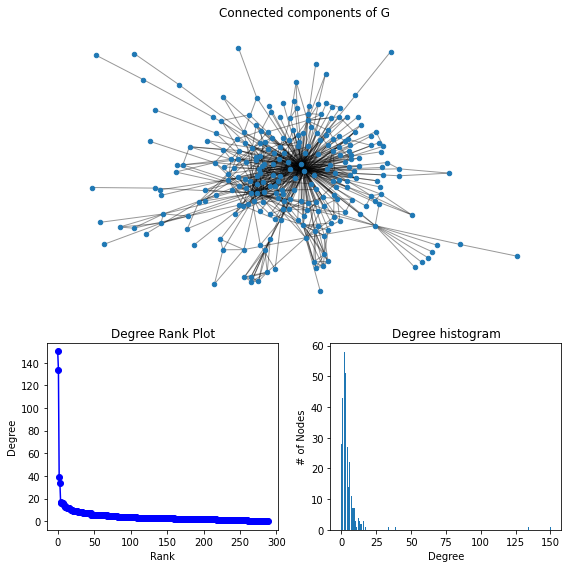

In [56]:
degree_sequence = sorted((d for n, d in G_un.degree()), reverse=True)
dmax = max(degree_sequence)

fig = plt.figure("Degree of a random graph", figsize=(8, 8))
# Create a gridspec for adding subplots of different sizes
axgrid = fig.add_gridspec(5, 4)

ax0 = fig.add_subplot(axgrid[0:3, :])
Gcc = G_un.subgraph(sorted(nx.connected_components(G_un), key=len, reverse=True)[0])
pos = nx.spring_layout(Gcc, seed=10396953)
nx.draw_networkx_nodes(Gcc, pos, ax=ax0, node_size=20)
nx.draw_networkx_edges(Gcc, pos, ax=ax0, alpha=0.4)
ax0.set_title("Connected components of G")
ax0.set_axis_off()

ax1 = fig.add_subplot(axgrid[3:, :2])
ax1.plot(degree_sequence, "b-", marker="o")
ax1.set_title("Degree Rank Plot")
ax1.set_ylabel("Degree")
ax1.set_xlabel("Rank")

ax2 = fig.add_subplot(axgrid[3:, 2:])
ax2.bar(*np.unique(degree_sequence, return_counts=True))
ax2.set_title("Degree histogram")
ax2.set_xlabel("Degree")
ax2.set_ylabel("# of Nodes")

fig.tight_layout()
plt.show()

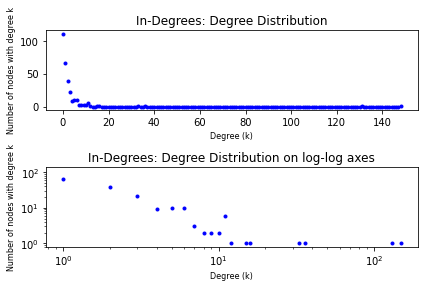

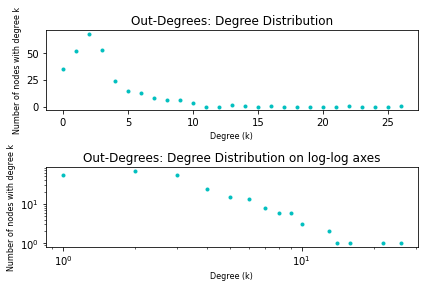

In [57]:
def plot_degree_distribution(degrees, title, color):
    counts, limits = np.histogram(degrees, degrees[0])

    x = limits[:len(counts)]
    y = counts

    ax1 = plt.subplot(2, 1, 1)
    ax1.plot(x, y, color)
    ax1.set_title(title)
    ax1.set_ylabel('Number of nodes with degree k',fontsize=8)
    ax1.set_xlabel('Degree (k)',fontsize=8)

    ax2 =plt.subplot(2, 1, 2)
    ax2.loglog(x, y, color)
    ax2.set_title(title + ' on log-log axes')
    ax2.set_ylabel('Number of nodes with degree k',fontsize=8)
    ax2.set_xlabel('Degree (k)',fontsize=8 )

    plt.tight_layout()
    plt.show()
        
    
in_degrees = sorted(list(G.in_degree()),key=lambda d: d[1], reverse=True)
out_degrees = sorted(list(G.out_degree()),key=lambda d: d[1], reverse=True)

in_only_degrees = [val for node,val in in_degrees]
out_only_degrees = [val for node,val in out_degrees]
    

plot_degree_distribution(in_only_degrees, "In-Degrees: Degree Distribution", 'b.')

plot_degree_distribution(out_only_degrees, "Out-Degrees: Degree Distribution", 'c.')

In the plots above we have the Degree of the hole undirect graph and after that the in and out degree of the graph. The degree of a node in a network is the number of connections or edges the node has where the in and out degree refers to only the number of in nodes and the out nodes of the graph. A metric as basic as the degree distribution can provide insight into a network's structure and help distinguish between various network types. From this analysis we can see that more than 90% of our nodes have less that 25 edges connected while a lot of them have 0 in-dregrees or 0 out-degrees edges. Last, almost 30 of our nodes dont have any connection with other nodes of the graph.

100%|██████████| 2000/2000 [00:04<00:00, 453.47it/s]


BarnesHut Approximation  took  0.71  seconds
Repulsion forces  took  3.43  seconds
Gravitational forces  took  0.03  seconds
Attraction forces  took  0.02  seconds
AdjustSpeedAndApplyForces step  took  0.12  seconds


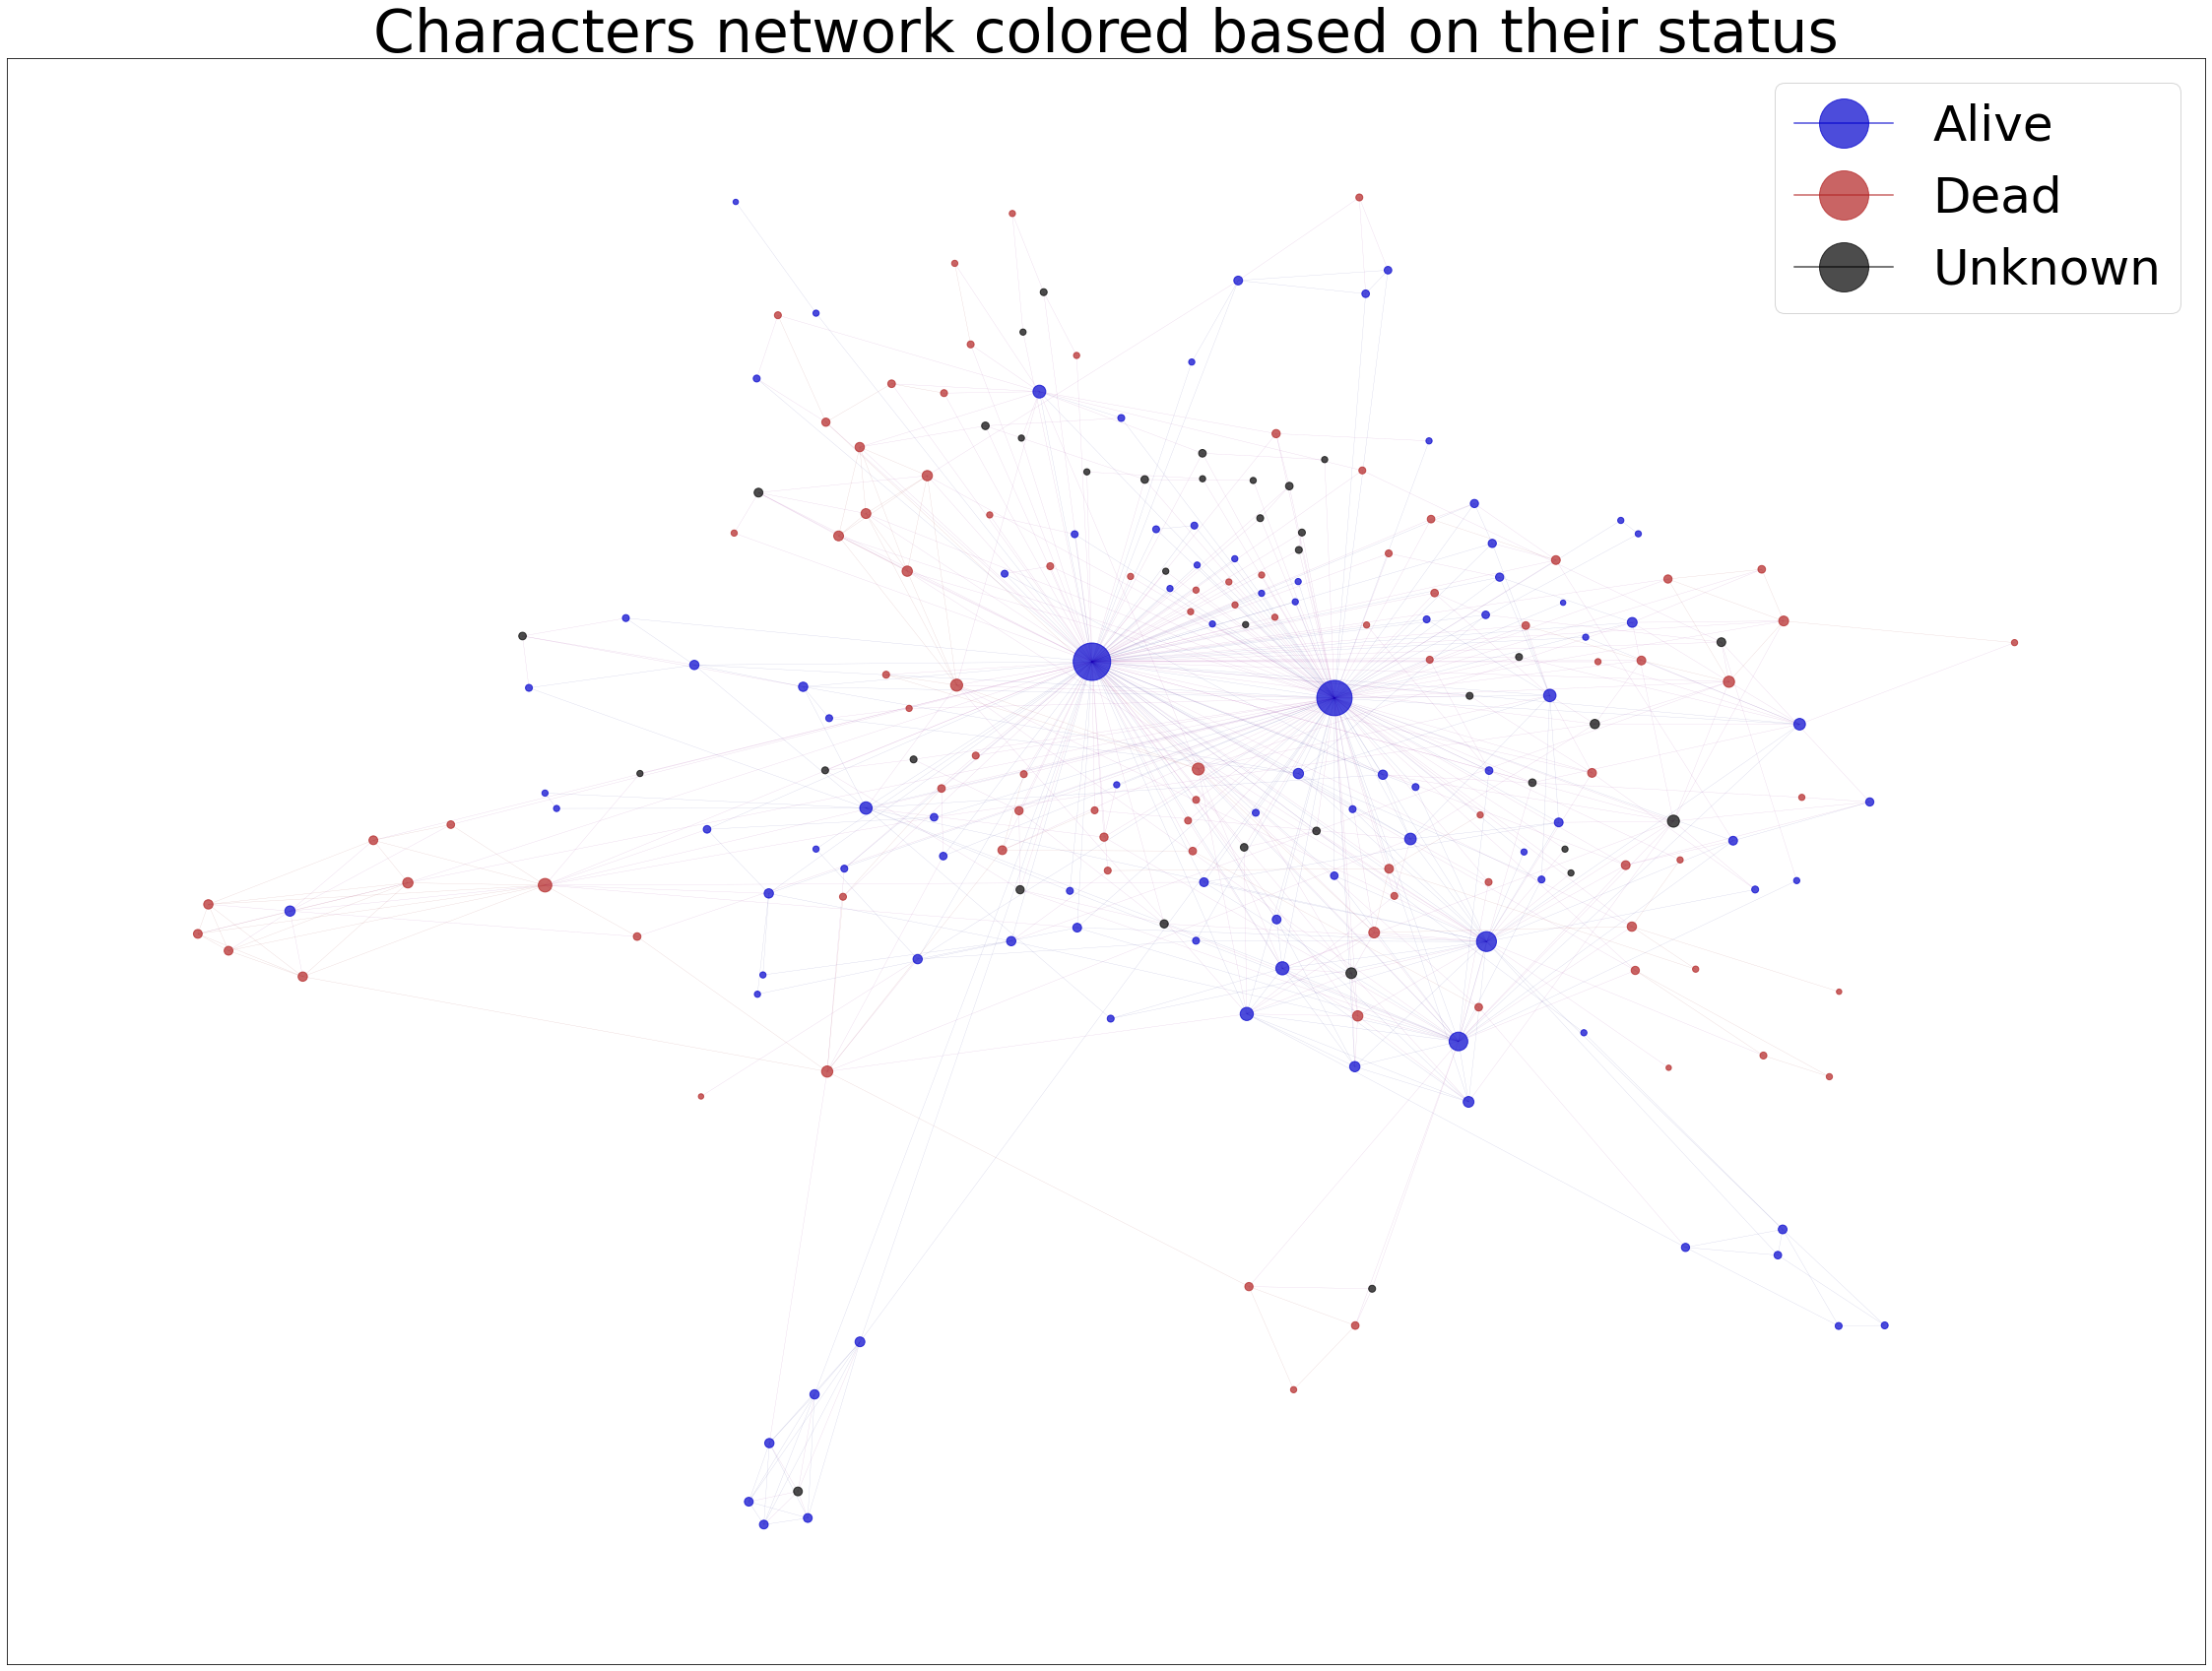

In [60]:
#Delete nodes with no edges
G_un.remove_nodes_from(list(nx.isolates(G_un)))

#Delete nodes with one edge
to_be_removed = [x for  x in G_un.nodes() if G_un.degree(x) <= 1]

for x in to_be_removed:
    G_un.remove_node(x)

#Color the nodes/edges
node_sizes = [val*10+20 for node, val in G_un.degree()]
node_colors = ['#0000CD' if node[1]['Status'] == "Alive" else '#B22222' if node[1]['Status'] == "Dead" else '#000000' for node in G_un.nodes(data=True)]
edge_colors = ['#000080' if G_un.nodes[node1]['Status'] == G_un.nodes[node2]['Status'] == "Alive"\
               else '#8B0000' if G_un.nodes[node1]['Status'] == G_un.nodes[node2]['Status'] == "Dead" \
               else '#8B008B' for node1,node2 in G_un.edges]

forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=False,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=0,

                        # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.0,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=1.0,
                        strongGravityMode=False,
                        gravity=-1,

                        # Log
                        verbose=True)

# plt.figure(figsize=(25,25))
# ax = plt.gca()
# ax.set_title('DC-Marvel Characters Network',fontsize = 40) 
args = {
'node_color': node_colors,
'edge_color':edge_colors,
'node_size':node_sizes,
'width':0.3,
'linewidths':0.3,
}

figure = plt.figure(figsize=(40,30))
# plt.savefig(figure, dpi=1200)
ax = plt.gca()
ax.set_title('Characters network colored based on their status',fontsize = 60) 

positions = forceatlas2.forceatlas2_networkx_layout(G_un, pos=None, iterations=2000)
#nx.draw(GCC_undirected,positions, **args, ax=ax)

nx.draw_networkx_nodes(
    G = G_un,
    node_size = node_sizes,
    pos = positions, 
    node_color = node_colors,
    alpha = 0.7
)
nx.draw_networkx_edges(
    G = G_un,
    pos = positions, 
    edge_color = edge_colors, 
    alpha = 0.2,
    width = 0.3
    #linewidths=0.3
)

legends = [Line2D([0], [0], marker='o', color='#0000CD', label= "Alive", markersize=50, alpha=0.7),
          Line2D([0], [0], marker='o', color='#B22222', label= "Dead", markersize=50, alpha=0.7),
          Line2D([0], [0], marker='o', color='#000000', label= "Unknown", markersize=50, alpha=0.7)]
plt.legend(handles = legends, loc = 1, fontsize = 50)
plt.show()

plt.show()

# Communities


In [ ]:
%run link_clustering.py -d , edges.txt

In [61]:
# Load Graph from the pickle
CG = nx.read_gpickle("../Data/final_graph.gpickle")

In [62]:
def check_nodes(G):
    d_out = dict(G.out_degree())
    key0_out = [k for k, v in d_out.items() if v == 0]
    # get the heros'name-list that out-degree is 0

    d_in = dict(G.in_degree())
    key0_in = [k for k, v in d_in.items() if v == 0]
    # get the heros'name-list that in-degree is 0

    nodesDegree_0 = []
    for i in key0_out:
        if i in key0_in:
            nodesDegree_0.append(i)
    G.remove_nodes_from(nodesDegree_0)
    return G

CG2=check_nodes(CG)

CG_un = nx.to_undirected(CG)

partitionC = community_louvain.best_partition(CG_un)

In [63]:
count = 0
for com in set(partitionC.values()) :
    count = count + 1
count
print(f"We got {count} communities form 'louvain communities'" )
communities_numbers = count

We got 18 communities form 'louvain communities'


### Draw the visualizesion of communities


100%|██████████| 2000/2000 [00:06<00:00, 313.77it/s]


BarnesHut Approximation  took  0.82  seconds
Repulsion forces  took  5.17  seconds
Gravitational forces  took  0.04  seconds
Attraction forces  took  0.03  seconds
AdjustSpeedAndApplyForces step  took  0.15  seconds


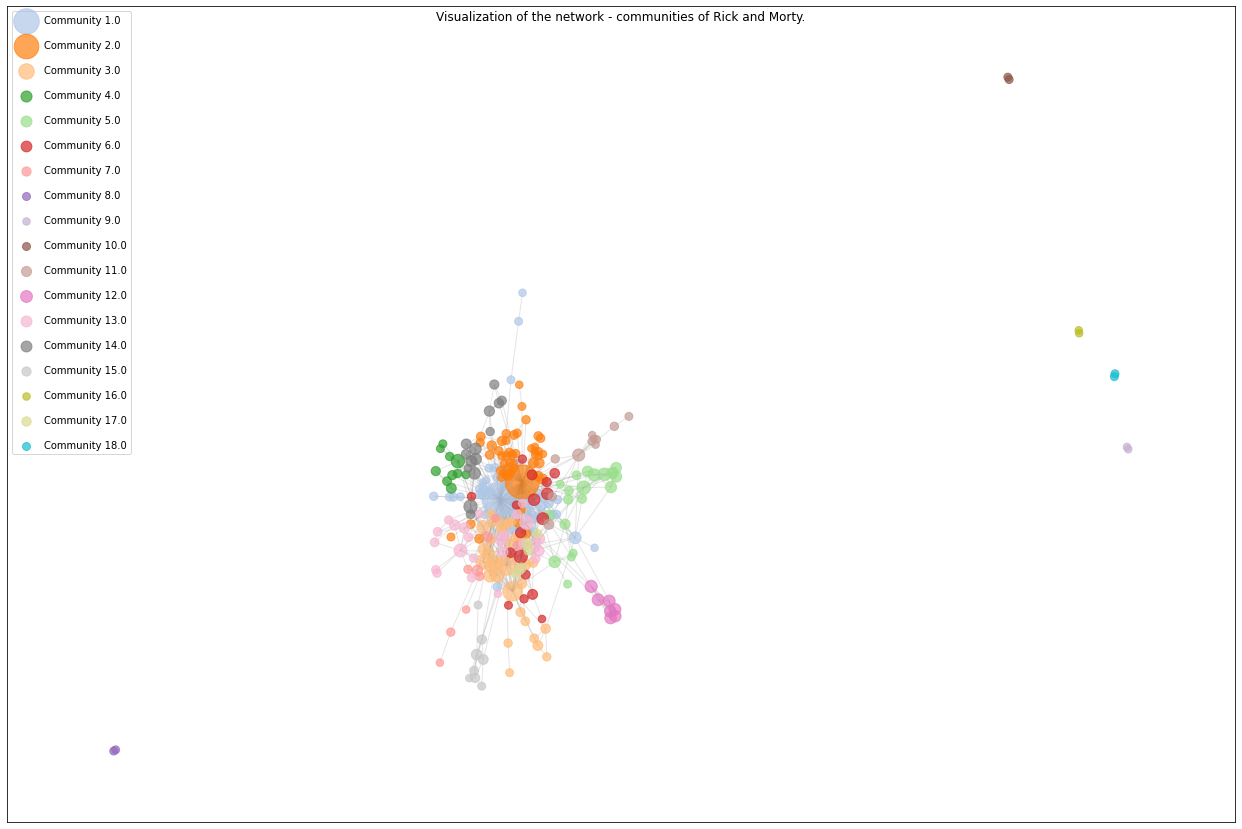

In [64]:
# plot network

fig, ax = plt.subplots(figsize=(22, 15))

forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=False,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=0,

                        # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.0,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=1.0,
                        strongGravityMode=False,
                        gravity=-1,

                        # Log
                        verbose=True)

pos = forceatlas2.forceatlas2_networkx_layout(CG_un, pos=None, iterations=2000)
# pos = nx.kamada_kawai_layout(CG_un)  # For some versions that can't install fa2

# create a random RMG-color list
blobs, labels = make_blobs(n_samples=1000, centers=25, center_box=(-100, 100))
P = sns.color_palette("tab20", 20).as_hex()

#drawing
d = dict(nx.degree(CG_un))
nodeSize=[v for v in d.values()]

count = 0.

for com in set(partitionC.values()) :
    count = count + 1.
    node_list = [nodes for nodes in partitionC.keys()
                                if partitionC[nodes] == com]
    list_nodes = node_list


    nodeSize_list=[]
    for node_ in node_list:
      nodeSize = (dict(CG_un.degree())[node_])*7+50
      nodeSize_list.append(nodeSize)
      
    lable_ = "Community {}".format(str(count))
    nx.draw_networkx_nodes(CG_un, pos, list_nodes,alpha = 0.7 ,node_size = nodeSize_list, node_color=P[int(count)],label=lable_)
 

nx.draw_networkx_edges(CG_un, pos, alpha=0.2, edge_color = 'grey')

plt.legend(labelspacing = 1.5)
plt.title('Visualization of the network - communities of Rick and Morty.', pad=-14)

plt.show()

Compute the partition of the graph nodes which maximises the modularity (or try..) using the Louvain heuristices
This is the partition of highest modularity, i.e. the highest partition of the dendrogram generated by the Louvain algorithm.

In [65]:
# Get best partition
partition = community.best_partition(G_un)
print('Modularity: ', community.modularity(partition, G_un))

Modularity:  0.42381657483930213


<Figure size 936x648 with 0 Axes>

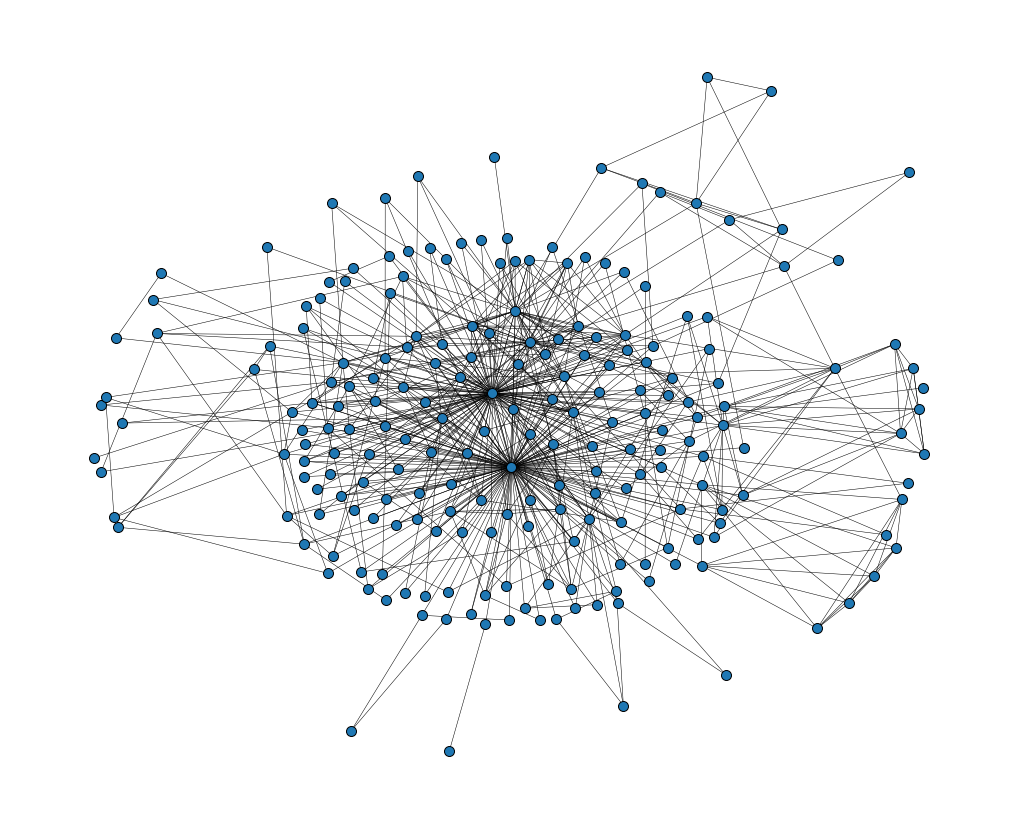

In [66]:
# Draw graph
plt.figure(figsize=(13, 9))
size = float(len(set(partition.values())))


plt.figure(figsize=(18,15))
pl = nx.draw_networkx(G_un,pos=nx.kamada_kawai_layout(G_un),with_labels=False,node_size = 100,width = 0.5 ,edgecolors = 'black')
plt.axis('off')
plt.show()

In [67]:
# Keep only communities with a minimum of connections
centers = {}
communities = {}
G_main_com = G_un.copy()
min_nb = 15


for com in set(partition.values()) :
    list_nodes = [nodes for nodes in partition.keys() if partition[nodes] == com]
    if len(list_nodes) < min_nb:
        G_main_com.remove_nodes_from(list_nodes)
    else:
        # Get center
        H = G_main_com.subgraph(list_nodes)
        d_c = nx.degree_centrality(H)
        center = max(d_c, key=d_c.get)
        centers[center] = com
        communities[com] = center
        # Print community
        print('Community of ', center , '(ID ', com, ') - ', len(list_nodes), ' connected characters:')
        print(list_nodes, '\n')

Community of  Rick Sanchez (ID  0 ) -  40  connected characters:
['Rick Sanchez', 'Albert Einstein', 'Alexander', 'Annie', 'Arthricia', 'Birdperson', 'Courier Flap', 'Cynthia', 'Dr. Xenon Bloom', 'Ethan', 'Fart', 'Gene', 'General Nathan', 'Gibble Snake', 'Gordon Lunas', 'Kevin', 'Krombopulos Michael', 'Lil B', 'Mr. Meeseeks', 'Mrs. Refrigerator', 'Poncho', 'Prince Nebulon', 'Purge Planet Ruler', 'Risotto Groupon', 'Roger', 'Ruben', 'Samantha', 'Scropon', 'Shleemypants', 'Shmooglite Runner', 'Shrimply Pibbles', 'Squanchy', 'Stu', 'Tusked Assassin', 'Wedding Bartender', 'Yellow Headed Doctor', 'Simon', 'Fascist Morty', 'Miles Knightly', 'Glar'] 

Community of  Summer Smith (ID  2 ) -  34  connected characters:
['Summer Smith', 'Beth Smith', "Beth's Mytholog", 'Colossus', 'Dale', 'Diane Sanchez', 'Dipper and Mabel Mortys', 'Evil Beth Clone', 'Evil Jerry Clone', 'Evil Summer Clone', 'Eyehole Man', 'Frank Palicky', 'Goddess Beth', 'Gwendolyn', 'Harold', 'Hemorrhage', 'Hunter', 'Ideal Jerry'

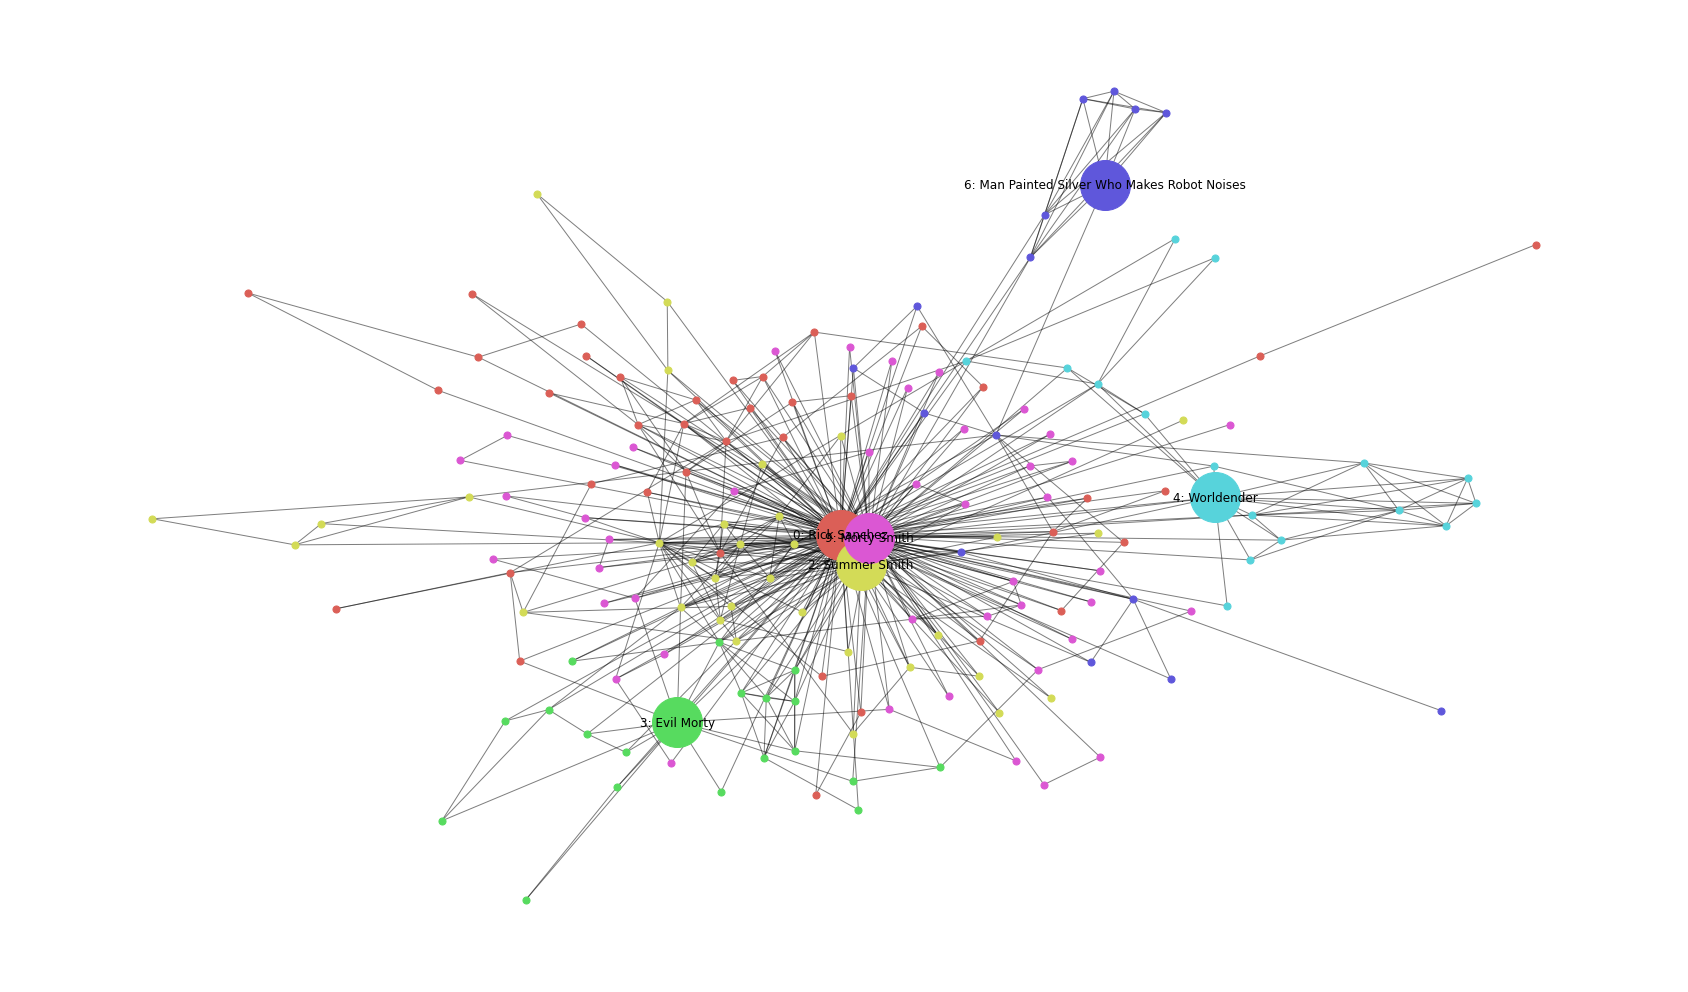

In [68]:
# Display graph
plt.figure(figsize=(30, 18))
node_size = 50
count = 0
pos = nx.spring_layout(G_main_com)
colors = dict(zip(communities.keys(), sns.color_palette('hls', len(communities.keys()))))

for com in communities.keys():
    count = count + 1
    list_nodes = [nodes for nodes in partition.keys() if partition[nodes] == com and nodes not in communities.values()]
    nx.draw_networkx_nodes(G_main_com, pos, list_nodes, node_size = node_size, node_color = colors[com])
    nx.draw_networkx_nodes(G_main_com, pos, list([communities[com]]), node_size = node_size*50, node_color = colors[com])
nx.draw_networkx_edges(G_main_com, pos, alpha=0.5)
labels = {k: str(v) + ': ' + k for k,v in centers.items()}
nx.draw_networkx_labels(G_main_com, pos, labels)
plt.axis('off')
plt.show()

In [69]:
#k-clique communities
communities = list(k_clique_communities(G_un, 3))

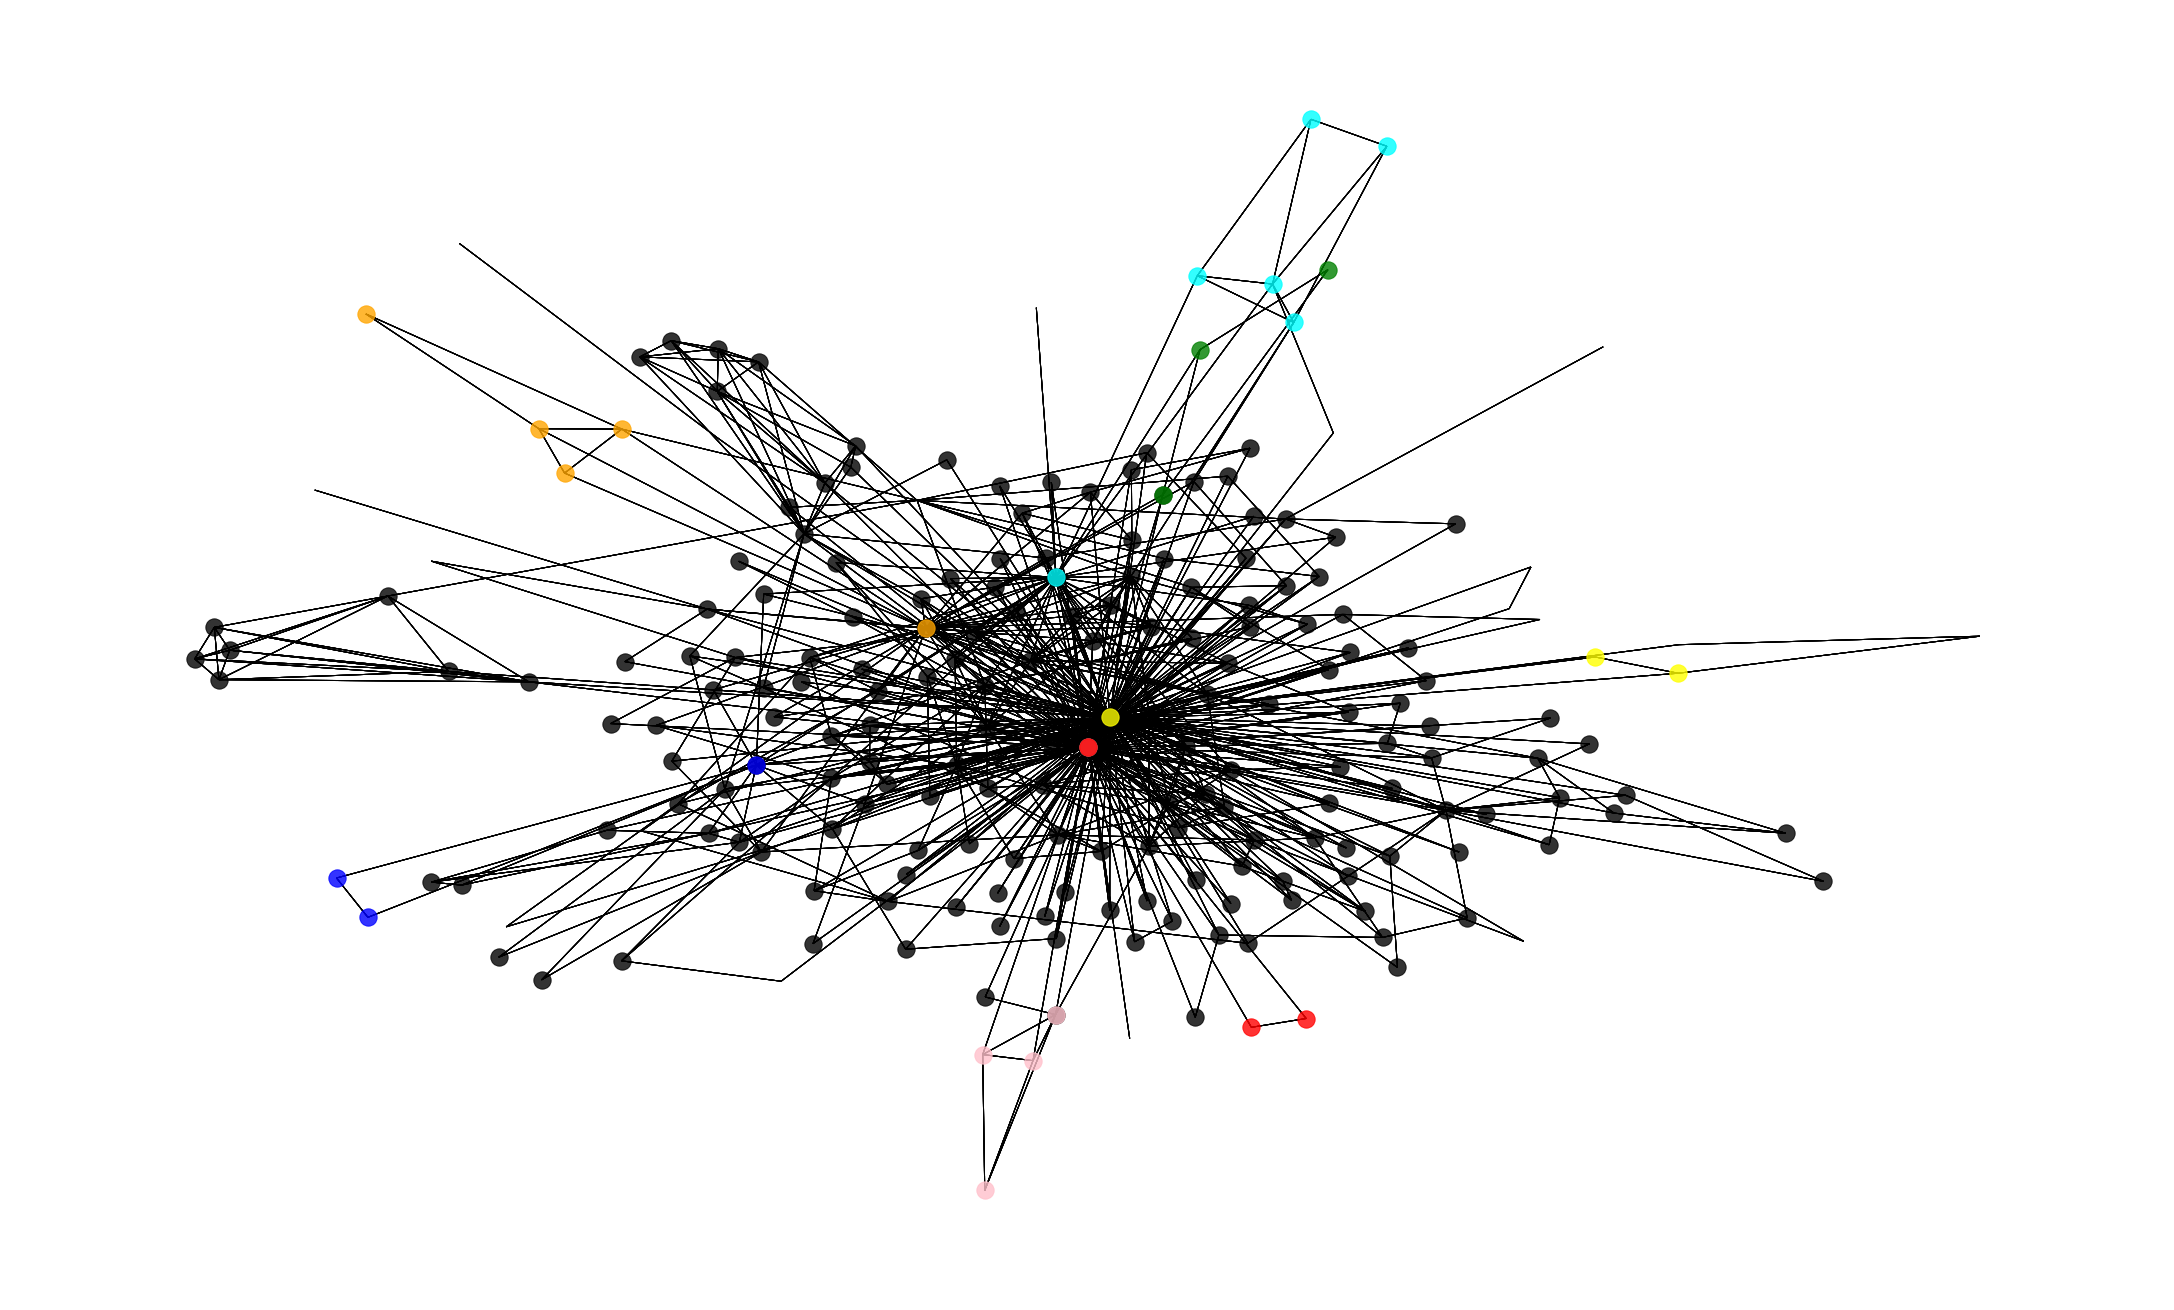

In [70]:
len(communities)

pos = nx.spring_layout(G_un)
colors = ["black", "orange", "cyan", "blue", "green", "yellow", "pink", "red"]

plt.figure(figsize=(30, 18))

for i in range(len(communities)):
    graph = communities[i]
    node_list = [node for node in graph]
    nx.draw(G_un, pos, nodelist=node_list, node_color=colors[i], alpha=0.8)
    
plt.show()

In [71]:
Characters = nx.read_gpickle("../Data/characters.pickle")

### Compare the original species and the communities creating by louvain method

In [72]:
# Creat a dict, keys are name, values are community number
node_list_all = []
Communitylist = []
count = 0
for com in set(partitionC.values()) :
    count = count + 1.
    node_list = [nodes for nodes in partitionC.keys()
                                if partitionC[nodes] == com]
    node_list_all = node_list_all + node_list
    
    Community_number = count
    
    for node in node_list:
        Communitylist.append(Community_number)

CommunityDict = {node_list_all[i]: Communitylist[i] for i in range(len(node_list_all))}

In [73]:
# Handle the data in dataframe 'Character', deleting the nodes(names) that without link to other nodes.
Characters_less = list(CommunityDict.keys()) 
Characters_more = Characters["Name"]
DeleteList = []
for name in Characters_more:
    if name not in Characters_less:
        DeleteList.append(name)

CharactersLess = Characters
for name_ in DeleteList:
    CharactersLess = CharactersLess[CharactersLess.Name != name_]

In [74]:
communityOrder_list = []
for name__ in list(CharactersLess["Name"]):
    communityOrder = int(CommunityDict[name__])
    communityOrder_list.append(communityOrder)

CharactersLess["community order"] = communityOrder_list

In [75]:
SpeciesList = list(CharactersLess["Species"])
countSpecies = list( dict.fromkeys(SpeciesList))
print(f'There are {len(countSpecies)} species in our characters dataframe of rick and morty. They are {countSpecies}')

SpeciesList_less = list((dict.fromkeys(SpeciesList)).keys())

There are 9 species in our characters dataframe of rick and morty. They are ['Human', 'Alien', 'Humanoid', 'unknown', 'Poopybutthole', 'Mythological Creature', 'Animal', 'Cronenberg', 'Robot']


In [76]:
specieOrder_list = []
for i in range(len(CharactersLess)):
    if list(CharactersLess["Species"])[i] == SpeciesList_less[0]:
        Character_specieOrder = 1
    elif list(CharactersLess["Species"])[i] == SpeciesList_less[1]:
        Character_specieOrder = 2
    elif list(CharactersLess["Species"])[i] == SpeciesList_less[2]:
        Character_specieOrder = 3
    elif list(CharactersLess["Species"])[i] == SpeciesList_less[3]:
        Character_specieOrder = 4
    elif list(CharactersLess["Species"])[i] == SpeciesList_less[4]:
        Character_specieOrder = 5
    elif list(CharactersLess["Species"])[i] == SpeciesList_less[5]:
        Character_specieOrder = 6
    elif list(CharactersLess["Species"])[i] == SpeciesList_less[6]:
        Character_specieOrder = 7
    elif list(CharactersLess["Species"])[i] == SpeciesList_less[7]:
        Character_specieOrder = 8
    elif list(CharactersLess["Species"])[i] == SpeciesList_less[8]:
        Character_specieOrder = 9

    specieOrder_list.append(Character_specieOrder)

CharactersLess['species order'] = specieOrder_list
CharactersLess

Name Species Status  \
0          Rick Sanchez   Human  Alive   
1           Morty Smith   Human  Alive   
2          Summer Smith   Human  Alive   
3            Beth Smith   Human  Alive   
4      Adjudicator Rick   Human   Dead   
..                  ...     ...    ...   
283  Priest Witherspoon   Human  Alive   
284             Richard   Human  Alive   
285        Running Bird   Human  Alive   
287      Miles Knightly   Alien   Dead   
288                Glar   Alien  Alive   

                                              ImageUrl  \
0    https://rickandmortyapi.com/api/character/avat...   
1    https://rickandmortyapi.com/api/character/avat...   
2    https://rickandmortyapi.com/api/character/avat...   
3    https://rickandmortyapi.com/api/character/avat...   
4    https://rickandmortyapi.com/api/character/avat...   
..                                                 ...   
283  https://rickandmortyapi.com/api/character/avat...   
284  https://rickandmortyapi.com/api/character/avat...   
285  https://rickandmortyapi.com/api/character/avat...   
287  https://rickandmortyapi.com/api/character/avat...   
288  https://rickandmortyapi.com/api/character/avat...   

                                     LastKnownLocation  \
0    {'name': 'Citadel of Ricks', 'url': 'https://r...   
1    {'name': 'Citadel of Ricks', 'url': 'https://r...   
2    {'name': 'Earth (Replacement Dimension)', 'url...   
3    {'name': 'Earth (Replacement Dimension)', 'url...   
4    {'name': 'Citadel of Ricks', 'url': 'https://r...   
..                                                 ...   
283  {'name': 'Earth (Replacement Dimension)', 'url...   
284  {'name': 'Earth (Replacement Dimension)', 'url...   
285  {'name': 'Earth (Replacement Dimension)', 'url...   
287  {'name': 'Heist-Con', 'url': 'https://rickandm...   
288  {'name': 'Heist-Con', 'url': 'https://rickandm...   

                                              Wikitext  community order  \
0    b'{{SimilarName|Rick Sanchez (C-137)|[[Rick (d...                1   
1    b'{{SimilarName|the main character we follow t...                2   
2    b'{{for|other versions of Summer Smith|Summer ...                3   
3    b'{{Character\n|name = Beth Smith\n|image = Be...                3   
4    b"{{Character|image = AdjudicatorRick.PNG|spec...                4   
..                                                 ...              ...   
283  b"{{Stub}}\n{{Character\n|image=[[File:Priest_...               15   
284  b"{{Stub}}\n{{Character\n|image=[[File:Richard...               15   
285  b"{{Stub}}\n{{Character\n|image=Running_Bird.p...               15   
287  b'{{Stub}}\n{{Character\n|name          = Mile...                1   
288  b'{{Stub}}\n{{Character\n|name = Glar\n|aka = ...                1   

     species order  
0                1  
1                1  
2                1  
3                1  
4                1  
..             ...  
283              1  
284              1  
285              1  
287              2  
288              2  

[261 rows x 8 columns]

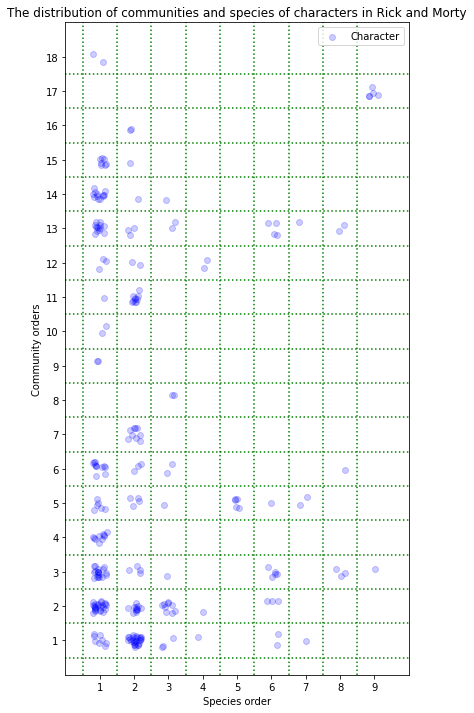

In [77]:
x = list(CharactersLess['species order'])
y = list(CharactersLess['community order'])

# Add a random numer for each node to observe the clustering
x_forPlot = []
for i in range(len(x)):
    number_x  = x[i] + random.uniform(-0.2, 0.2)
    x_forPlot.append(number_x)

y_forPlot = []
for j in range(len(x)):
    number_y  = y[j] + random.uniform(-0.2, 0.2)
    y_forPlot.append(number_y)
      
# Plotting
colors = "blue"
plt.figure(figsize=(12,12))
xtick = list(range(1,max(x)+1))
xline = [x - 0.5 for x in xtick]
ytick = list(range(1,max(y)+1))
yline = [y - 0.5 for y in ytick]
for numberx in xline:
    plt.axvline(x = numberx, color ="green", linestyle =":")
for numbery in yline:
    plt.axhline(y = numbery, color ="green", linestyle =":")

plt.xlim((0,max(x)+1))
plt.ylim((0,max(y)+1))
plt.scatter(x_forPlot, y_forPlot, c=colors, alpha=0.2, label='Character')
plt.ylabel('Community orders',fontsize=10)
plt.xlabel('Species order',fontsize=10)
plt.legend()
plt.title('The distribution of communities and species of characters in Rick and Morty')
plt.xticks(list(range(1,max(x)+1)),[str(i) for i in range(1,max(x)+1)])
plt.yticks(list(range(1,max(y)+1)),[str(j) for j in range(1,max(y)+1)])
plt.gca().set_aspect(1)

From the scatter plot above, we can see that, for each community, the nodes(characters) are mostly concentrated in one or a few fixed species. For example, Community 1 mainly gather in species 1, species 2 and species 9. Community 11 mainly concentrated in species 2 and species 5. However, for each species, the concentration of specific communities is not obvious. 

We used 'community_louvain.best_partition' to create communites. Its internal principles come from Louvain method. The Louvain method generally consists of two steps. To create communities, grab nodes in denser areas of the network. Next, Defining a network from the communities found in step 1. The above two steps are repeated until no further reassignments of communities are possible. So when we using it to create the communities, it get communities from the nodes that connections are relatively dense. So the distrubution for each community is easy to be in a few species. 

### Wordcloulds for each community (create by louvain method)

In [78]:
# Get the single words for every character page.
tokens_list = []
for i in range(len(CharactersLess)):
  try:
    Str__ = str(list(CharactersLess["Wikitext"])[i])
    wikitext_1 = Str__ .replace("\\n", " ")
    wikitext_2 = wikitext_1.replace("\'", " ")
    wikitext_3 = wikitext_2.replace("\\u", " ")
    wikitext_4 = wikitext_3.replace("xe2x80x93", " ")
    
    # Remove all punctuation from your list of tokens
    text = wikitext_4.translate(str.maketrans('', '', string.punctuation))
    # Set everything to lowercase
    text = text.lower()
    # Divide the whole string into words
    tokens = word_tokenize(text)

    # Delete the stopwords in the text
    from stop_words import get_stop_words
    from nltk.corpus import stopwords

    stop_words = list(get_stop_words('en'))         #Have around 900 stopwords
    nltk_words = list(stopwords.words('english'))   #Have around 150 stopwords
    stop_words.extend(nltk_words)
    tokens_ = []
    for words in tokens:
        if not words in stop_words:
            tokens_.append(words)

    # Remove the words that too short or too long
    tokens_1 = []
    for i in range(len(tokens_)):
        if 2 < len(tokens_[i]) <12 :
            tokens_1.append(tokens_[i])

    tokens_list.append(tokens_1)
    
  
  except:
    print(f'{i} The {CharactersLess["Name"][i]} failed.')
    tokens_list.append(['-'])
     

  # Characters["Wiki text tokens"] = WikiText_tokens

CharactersLess['token list'] = tokens_list

In [79]:
# Creat a communite data frame. One row shows informations of one community.

# Get names for each community
comm_numbers_list = range(1, communities_numbers+1)
community_names_list = []
for i in range(len(comm_numbers_list)):
  namesList = list(CharactersLess.loc[CharactersLess['community order'] == float(comm_numbers_list[i]), 'Name'])
  community_names_list.append(namesList )

# Get tokens for each community
community_tokens_list = []
for i in range(len(comm_numbers_list)):
  tokensList = list(CharactersLess.loc[CharactersLess['community order'] == float(comm_numbers_list[i]), 'token list'])
  community_tokens = []
  for i in range(len(tokensList)):
      community_tokens = community_tokens + tokensList[i]
  community_tokens_list.append(community_tokens)

title_column = {"community order":comm_numbers_list,
                "names":community_names_list,
                "tokens":community_tokens_list,
                }
Communities = pd.DataFrame(title_column)

In [80]:
def Create_dict(test_keys, test_values):
    Dict_ = {}
    for key in test_keys:
        for value in test_values:
            Dict_ [key] = value
            test_values.remove(value)
            break
    return Dict_ 

def get_frequencyDict(tokens):
    fdist1 = nltk.FreqDist(tokens)
    # count the frequency of every words
    dict_frequency = dict(fdist1.most_common())
    # Get most common X with dict
    return dict_frequency

def computeTF_bylist(wordlist): 
    tfDict = {}
    bowCount = len(wordlist)
    wordDict = get_frequencyDict(wordlist)
    for word, count in wordDict.items():
        tfDict[word] = format((count/float(bowCount)))
         
    tfDict = dict(sorted(tfDict.items(), key=lambda item: item[1], reverse=True)) # sort
    return tfDict

In [81]:
communityTF_list = []
for i in range(len(Communities)):
  wordlist_ = get_frequencyDict(Communities['tokens'][i])
  communityTF = computeTF_bylist(wordlist_)
  communityTF_list.append(communityTF)

Communities['TF'] = communityTF_list

In [82]:
# 
WordList_withRow = list(Communities['tokens'])

idfDict_list = []
for j in range(len(Communities)):
    WordList_dict = Communities['TF'][j]
    # Take the largest 1000 words to reduce the calculation time
    Length = len(WordList_dict)
    if Length > 200:
        WordList_less = dict(itertools.islice(WordList_dict.items(), 200))
    else:
        WordList_less = WordList_dict
    Name_list = list(WordList_less.keys())

    word_count = []
    for word in Name_list:
            count = 0
            for j in range(len(WordList_withRow)):
                if word in WordList_withRow[j]:
                    count += 1
            word_count.append(count)

    DictWords_counts = Create_dict(Name_list, word_count)
    idfDict = {}
    N = len(Communities)
    for word, val in DictWords_counts.items():
        idfDict[word] = math.log10(N / float(val))

    idfDict = dict(sorted(idfDict.items(), key=lambda item: item[1], reverse=True)) # sorted

    idfDict_list.append(idfDict)

Communities['IDF'] = idfDict_list

# Got the TFIDF for each community
Community_tfidf_list=[]
for k in range(len(Communities)):
    Dict_name_IDF = list(Communities['IDF'])[k]
    for i in range(len(Dict_name_IDF)):
        idf_list = list(Dict_name_IDF.values())
        tf_list = list(list(Communities['TF'])[0].values())

        tfidf_list = []
        for j in range(len(idf_list)):
            tf_idf = float(idf_list[j]) * float(tf_list[j]) + 0.0001  # +0.0001 is for using in wordclouds function
            tfidf_list.append(tf_idf)

        Name_list = list(Dict_name_IDF.keys())
        Name_IFIDF_dict = Create_dict(Name_list,tfidf_list)

    Community_tfidf_list.append(Name_IFIDF_dict)

Communities['TFIDF'] = Community_tfidf_list

# Sort the communities from largest to smallest
Communities['len'] = Communities['TFIDF'].str.len()
Communities_sort = Communities.sort_values(by='len', ascending=False).drop(columns='len')
Communities_sort

community order                                              names  \
0                 1  [Rick Sanchez, Albert Einstein, Bearded Lady, ...   
14               15  [David Letterman, Glootie, Jeff, Josiah, Maggi...   
2                 3  [Summer Smith, Beth Smith, Beth's Mytholog, Co...   
3                 4  [Adjudicator Rick, Cool Rick, Evil Morty, Garm...   
4                 5  [Alan Rails, Arcade Alien, Baby Poopybutthole,...   
5                 6  [Alexander, Annie, Armagheadon, Arthricia, Dr....   
6                 7  [Amish Cyborg, Baby Wizard, Cousin Nicky, Duck...   
15               16                  [Frankenstein's Monster, Tinkles]   
1                 2  [Morty Smith, Alien Googah, Alien Morty, Alien...   
10               11  [Beta-Seven, Blim Blam, Daron Jefferson, Gar G...   
12               13  [Brad, Brad Anderson, Centaur, Davin, Dr. Wong...   
13               14  [Commander Rick, Glasses Morty, Cornvelious Da...   
16               17  [Mechanical Morty, Mechanical Rick, Mechanical...   
11               12  [Bobby Moynihan, Garmanarnar, Hole in the Wall...   
9                10                          [Baby Legs, Regular Legs]   
8                 9                          [Attila Starwar, Fulgora]   
17               18                   [Michael McLick, Randy Dicknose]   
7                 8               [Michael Thompson, Pichael Thompson]   

                                               tokens  \
0   [sanchez, c137rick, versions, rick, character,...   
14  [stub, character, name, david, letterman, imag...   
2   [forother, versions, summer, smithsummer, quot...   
3   [humanage, 70status, deceasedjob, adjudicator,...   
4   [quoteall, aboard, rails, last, words, charact...   
5   [bcharacter, name, alexander, image, origin, a...   
6   [amish, half, human, half, robotstatus, total,...   
15  [quotei, wrong, side, pitchfork, monster, lear...   
1   [main, character, follow, showmorty, versions,...   
10  [character, name, betaseven, image, origin, sp...   
12  [character, name, brad, image, species, human,...   
13  [character, image, species, human, status, min...   
16  [quotei, wan, alive, alive, alive, tell, repla...   
11  [character, name, bobby, moynihan, image, spec...   
9   [stub, character, name, baby, legs, image, bab...   
8   [character, nameattila, starwar, jobsoldier, f...   
17  [character, name, michael, mclick, image, mich...   
7   [character, job, news, pichael, thompson, conj...   

                                                   TF  \
0   {'rick': '0.16391668920746552', 'morty': '0.05...   
14  {'characters': '0.06744868035190615', 'app': '...   
2   {'rick': '0.10374554102259215', 'beth': '0.090...   
3   {'rick': '0.15275459098497496', 'morty': '0.13...   
4   {'rick': '0.07722772277227723', 'vindicators':...   
5   {'rick': '0.06288032454361055', 'morty': '0.05...   
6   {'characters': '0.06912442396313365', 'rick': ...   
15  {'monster': '0.06415094339622641', 'tinkles': ...   
1   {'morty': '0.183004455760662', 'rick': '0.1680...   
10  {'unity': '0.0876944837340877', 'rick': '0.057...   
12  {'rick': '0.09087423312883436', 'morty': '0.07...   
13  {'rick': '0.23194562446898895', 'morty': '0.09...   
16  {'rick': '0.11616161616161616', 'morty': '0.10...   
11  {'xe2x80x93': '0.24705882352941178', 'moynihan...   
9   {'legs': '0.20300751879699247', 'baby': '0.135...   
8   {'rick': '0.08771929824561403', 'morty': '0.08...   
17  {'man': '0.10526315789473684', 'car': '0.10526...   
7   {'thompson': '0.18181818181818182', 'cable': '...   

                                                  IDF  \
0   {'miniverse': 1.255272505103306, 'nebulon': 1....   
14  {'app': 1.255272505103306, 'glootie': 1.255272...   
2   {'s2e4': 1.255272505103306, 'joyce': 1.2552725...   
3   {'iii': 1.255272505103306, 'regional': 1.25527...   
4   {'supernova': 1.255272505103306, 'ants': 1.255...   
5   {'ruben': 1.255272505103306, 'poncho': 1.25527...   
6   {'giraffe': 1.255272505103

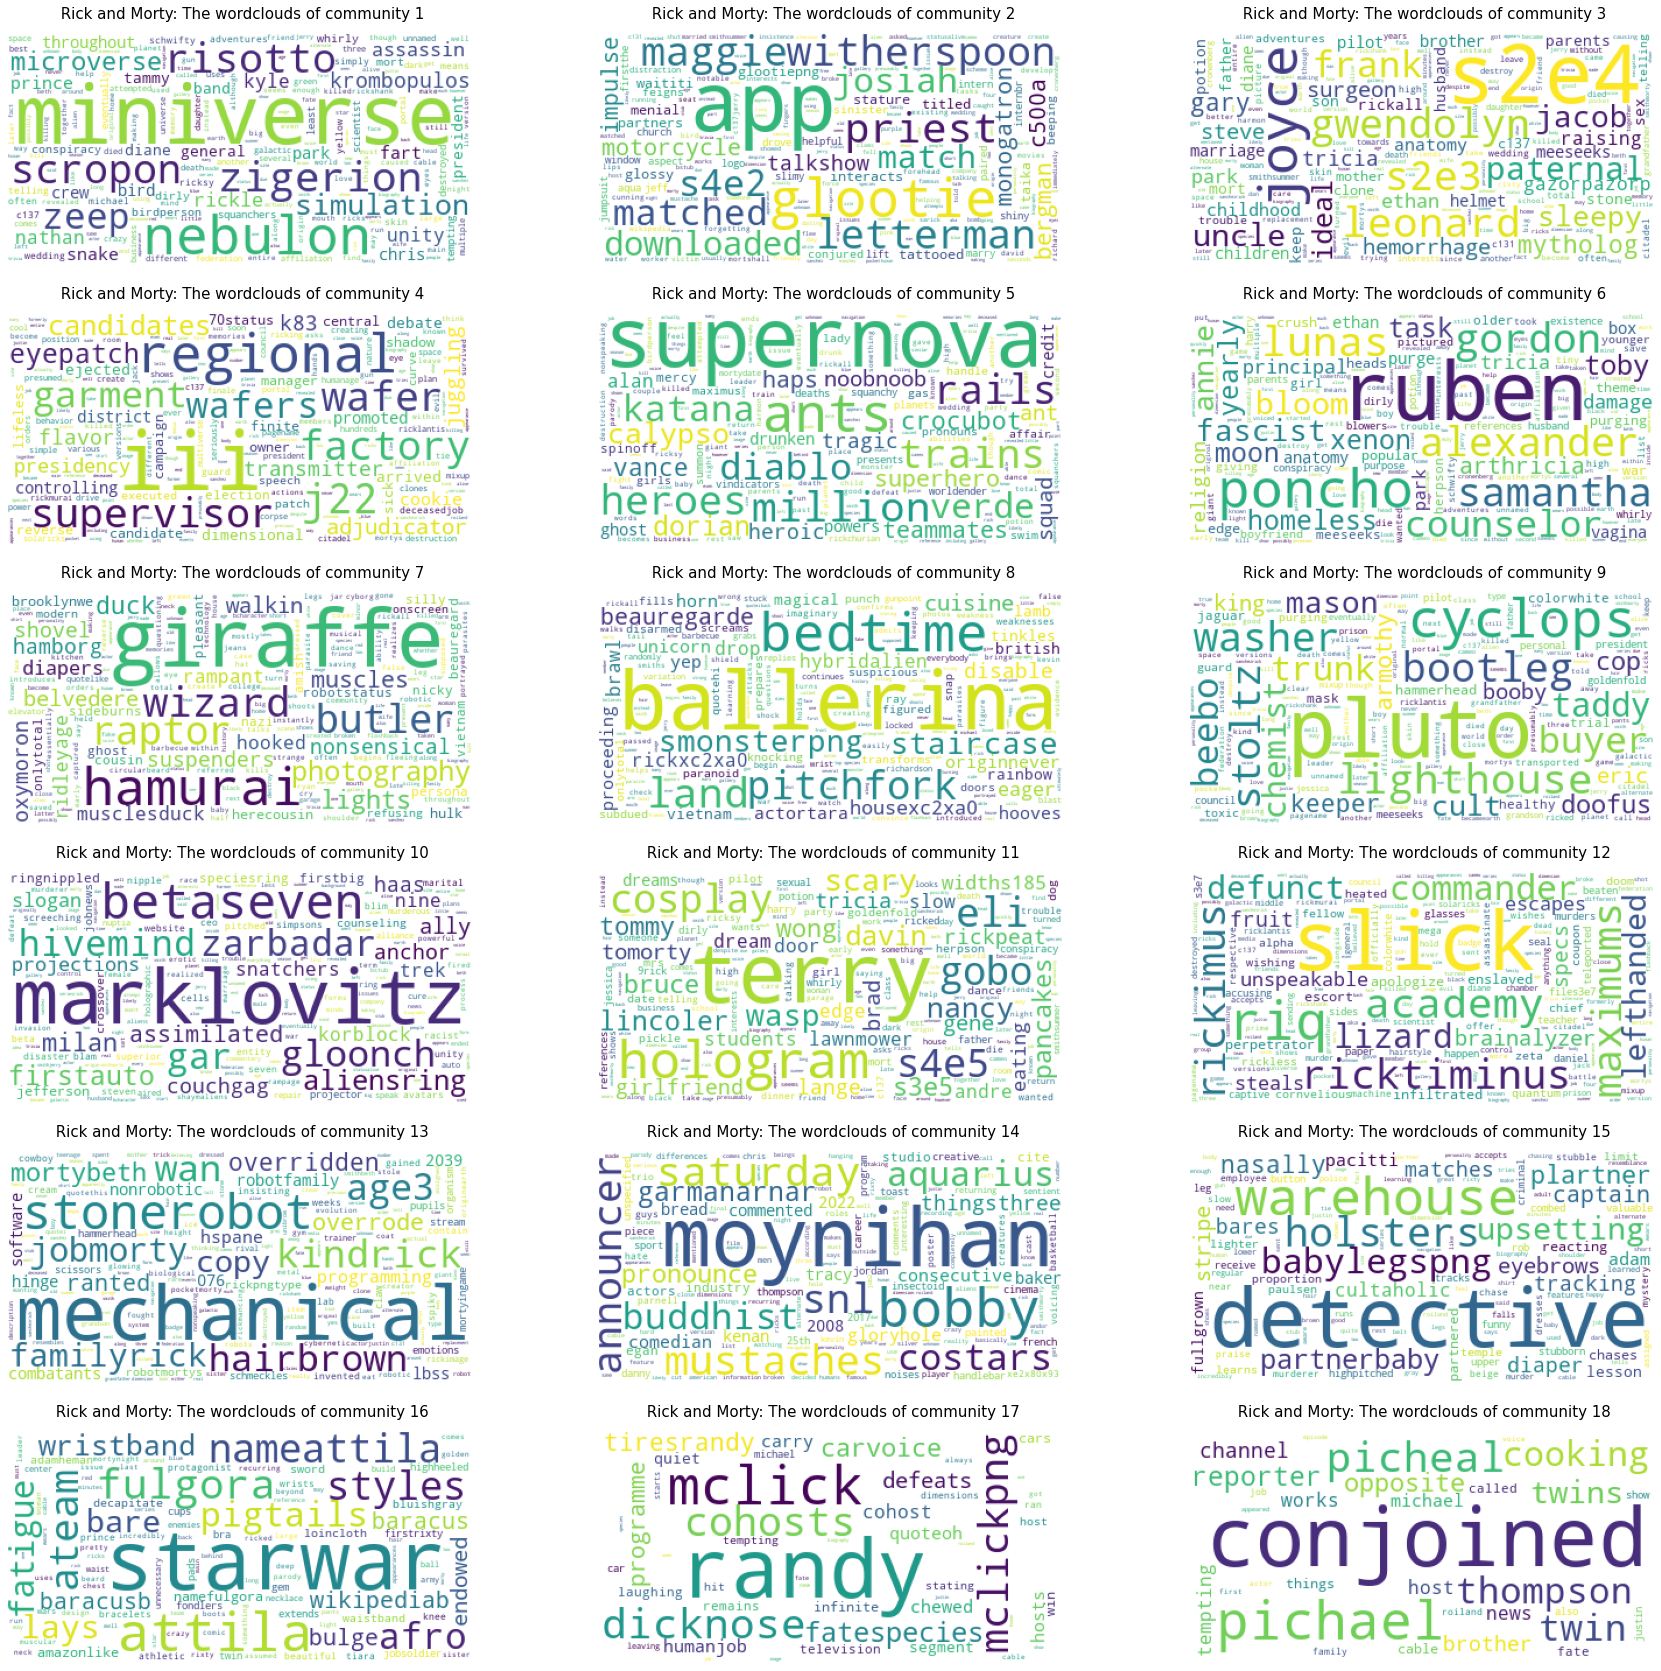

In [83]:
# Ploting
if len(Communities) >18:
  fig, axs = plt.subplots(nrows=7, ncols = 3, figsize = (30, 30))
  for i in range(len(Communities_sort)):
    wordcloud_ = WordCloud(background_color='white',max_font_size = 70)
    tf_idf_ = list(Communities_sort["TFIDF"])[i]
    wordcloud_.generate_from_frequencies(frequencies=tf_idf_) 
    if i <= 2:
      axs_x = 0
    elif 2 < i <= 5:
      axs_x = 1
    elif 5 < i <= 8:
      axs_x = 2
    elif 8 < i <= 11:
      axs_x = 3
    elif 11 < i <= 14:
      axs_x = 4
    elif 14 < i <= 17:
      axs_x = 5
    elif 17 < i <= 20:
      axs_x = 6

    if i in [i for i in range(30) if i % 3 == 0]:
      axs_y = 0
    elif (i - 1) in [i for i in range(30) if i % 3 == 0]:
      axs_y = 1
    elif (i - 2) in [i for i in range(30) if i % 3 == 0]:
      axs_y = 2
    axs[axs_x, axs_y].imshow(wordcloud_)
    title_ = ' Rick and Morty: The wordclouds of community {}'.format(i+1)
    axs[axs_x, axs_y].set_title(title_, fontsize = 15, pad=14)
    axs[axs_x, axs_y].axis("off")

else:
  fig, axs = plt.subplots(nrows=6, ncols = 3, figsize = (30, 30))
  for i in range(len(Communities_sort)):
    wordcloud_ = WordCloud(background_color='white',max_font_size = 70)
    tf_idf_ = list(Communities_sort["TFIDF"])[i]
    wordcloud_.generate_from_frequencies(frequencies=tf_idf_) 
    if i <= 2:
      axs_x = 0
    elif 2 < i <= 5:
      axs_x = 1
    elif 5 < i <= 8:
      axs_x = 2
    elif 8 < i <= 11:
      axs_x = 3
    elif 11 < i <= 14:
      axs_x = 4
    elif 14 < i <= 17:
      axs_x = 5

    if i in [i for i in range(30) if i % 3 == 0]:
      axs_y = 0
    elif (i - 1) in [i for i in range(30) if i % 3 == 0]:
      axs_y = 1
    elif (i - 2) in [i for i in range(30) if i % 3 == 0]:
      axs_y = 2
    axs[axs_x, axs_y].imshow(wordcloud_)
    title_ = ' Rick and Morty: The wordclouds of community {}'.format(i+1)
    axs[axs_x, axs_y].set_title(title_, fontsize = 15, pad=14)
    axs[axs_x, axs_y].axis("off")

# Centrality


In [84]:
N=15

# betweeness centrality
betweeness_centrality_dict = nx.betweenness_centrality(G_un)
betweeness_centrality_dict = dict(sorted(betweeness_centrality_dict.items(), reverse=True, key=lambda item: item[1]))
print(N, "most central characters according to betweeness centrality : ")
for i in range (N):
    character_name_i = list(betweeness_centrality_dict.keys())[i]
    print(f"- {character_name_i} : {betweeness_centrality_dict[character_name_i]}")

15 most central characters according to betweeness centrality : 
- Rick Sanchez : 0.5300398994038592
- Morty Smith : 0.3687626738929238
- Summer Smith : 0.06515615048059782
- Beth Smith : 0.05717667969827069
- Bobby Moynihan : 0.028829925479311087
- Eli : 0.027130002677570597
- Worldender : 0.023264785426629478
- Doom-Nomitron : 0.01744619411759451
- Evil Morty : 0.015512700855574548
- Reverse Giraffe : 0.014945683674966572
- Piece of Toast : 0.013760352479630528
- Morty Jr. : 0.012611461698559723
- Noob-Noob : 0.011814566618074054
- Evil Beth Clone : 0.011602814843398713
- Unity : 0.011322596620301514


In [85]:
degree_centrality_dict = nx.algorithms.centrality.degree_centrality(G_un)
degree_centrality_dict = dict(sorted(degree_centrality_dict.items(), reverse=True, key=lambda item: item[1]))
print(N,"most central characters according to degree centrality : ")
for i in range (N):
    character_name_i = list(degree_centrality_dict.keys())[i]
    print(f"- {character_name_i} : {degree_centrality_dict[character_name_i]}")

15 most central characters according to degree centrality : 
- Rick Sanchez : 0.6589861751152074
- Morty Smith : 0.5852534562211982
- Summer Smith : 0.17972350230414746
- Beth Smith : 0.15668202764976957
- Worldender : 0.07834101382488479
- Hemorrhage : 0.07373271889400922
- Morty Jr. : 0.07373271889400922
- Evil Morty : 0.06912442396313365
- Eli : 0.06451612903225806
- Jessica : 0.06451612903225806
- Diane Sanchez : 0.059907834101382486
- Ethan : 0.059907834101382486
- Rick Prime : 0.059907834101382486
- Birdperson : 0.05529953917050691
- Brad : 0.05529953917050691


In [86]:
degree_centrality_dict = nx.algorithms.centrality.voterank(G_un,N)
#degree_centrality_dict = dict(sorted(degree_centrality_dict.items(), reverse=True, key=lambda item: item[1]))
print("list of",N,"influential nodes in a graph using VoteRank algorithm : ")
for i in range (N):
    character_name_i = degree_centrality_dict[i]
    print(character_name_i)

list of 15 influential nodes in a graph using VoteRank algorithm : 
Rick Sanchez
Morty Smith
Summer Smith
Beth Smith
Worldender
Evil Morty
Chris
Eli
Jessica
Birdperson
Bobby Moynihan
Supernova
Ethan
Jeff
Morty Jr.


What defines an important vertex? is the question that centrality indices seek to address. The solution is expressed in terms of a real-valued function on a graph's vertices, with the values generated intended to create a ranking that identifies the important nodes.  There are many various definitions of centrality since the word "important" has so many diverse meanings. Thats why we run three different alorithms betweeness centrality, degree centrality and the voterank algorithm. What comes out of all these algorithms is that Rick Sanchez, Morty Smith, Summer Smith and Beth Smith are by far the most important nodes of our graph. For the other nodes the defferent algorithms are not consistent but some of the names that is worth mentioning probably are Worldender, Evil Morty, Eli and Morty Jr. 

# Sentiment Analysis

* Sentiment per Season
* Sentiment per Episode
* Sentiment throughout the episode
* Relation between Episode's Sentiment and IMDB rank

### Get the Data
* The transcripts of the first 3 seasons
* The labMT

The labMT 1.0.txt file containing the happiness rating for 10,222 words was obtained from [Temporal Patterns of Happiness and Information in a Global Social Network: Hedonometrics and Twitter](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0026752). In short it was constructed as follows:

For the word list, they consulted three sources. Twitter, English-language Google Books, 1960-2007 music lyrics, and the New York Times (1987-2007). They created word lists for each corpus that were arranged according to decreasing frequency of occurrence, then combined the top 5,000 words from each source to create a composite collection of 10,222 unique words.


They obtained 50 independent evaluations for each word by asking Mechanical Turk users to judge how a word made them feel on a nine-point integer scale. They divided the larger assignment into 100 smaller jobs, each requiring the evaluation of roughly 100 randomly chosen words. They highlighted the numbers 1, 3, 5, 7, and 9 using stylised expressions that ranged from unhappy to pleased.

In the paper they also describe that after some experimentation on which values should be considered neutral they discarded the words that had evaluation from 4 to 6. 

For our case we discarded the words that had evaluation from 4 to 6. This, because the wiki pages have generally a neutral tone. Therefore, when we tried to discard all the words with evaluation from 4 to 6 about 200 characters out of the 2200 were found to have no word in their wiki-page that is in the labMT wordlist. 

In [87]:
transcripts_df = pd.read_csv("../Data/transcripts.csv")

In [88]:
labmit1 = pd.read_table("../Data/labMIT-1.0.txt")

#create a dictionary with key the word and value the happinesss average
labmit1_dictionary = dict(zip(labmit1["word"], labmit1["happiness_average"]))

#remove words with sentiment from 4 to 6 
labmit1_dictionary = {word: sentiment for word, sentiment 
                                in labmit1_dictionary.items() 
                                if sentiment <= 4 or sentiment >= 6}

def calculate_sentiment(tokens_list):
    freq = nltk.FreqDist(w for w in tokens_list if w in labmit1_dictionary.keys())
    freq_count = sum(list(freq.values())) 
    sentiment_count = sum(labmit1_dictionary[w]*freq[w] for w in freq.keys())
    if(freq_count != 0):
        return sentiment_count/freq_count
    else:
        return -1
    
def tokenize_and_lemmatize(x):
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    lemmatizer = nltk.WordNetLemmatizer()
    
    tokens = tokenizer.tokenize(x)
    lemmatized_tokens = [ lemmatizer.lemmatize(token) for token in tokens]
    return lemmatized_tokens

## Sentiment per episode

In this section we are going to compute the sentiment score of each episode using its transcript and watch how it fluctuates during each season as well as check if there is a sopecific pattern.

### Data preprocessing

* Turn the trasncript text to lowercase
* Tokenize (removing also the punctuation) and lemmatize the transcripts

In [89]:
transcripts_df['transcript'] = transcripts_df['transcript'].str.lower()
transcripts_df['transcript'] = transcripts_df['transcript'].apply(tokenize_and_lemmatize)

### Calculate sentiment score for each episode based on labMT dictionary


In [90]:
transcripts_df['sentiment_score'] = transcripts_df['transcript'].apply(calculate_sentiment)

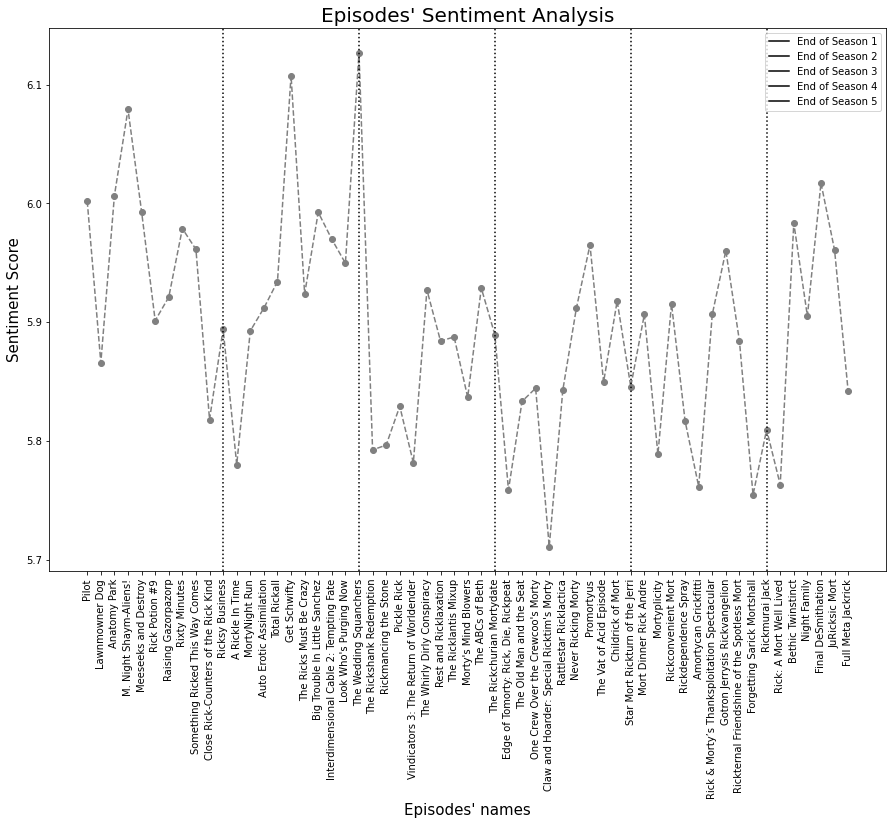

In [91]:
# plot 
fig, ax = plt.subplots(figsize = (15,10))
#plt.bar(transcripts_df['episode_name'], transcripts_df['sentiment_score'])

#plt.step(transcripts_df['episode_name'], transcripts_df['sentiment_score'], label='pre (default)')
plt.plot(transcripts_df['episode_name'], transcripts_df['sentiment_score'], 'o--', color='grey')
legends = [Line2D([0], [0], marker=None, color="k", label= "End of Season 1"),
          Line2D([0], [0], marker=None, color="k", label= "End of Season 2"),
          Line2D([0], [0], marker=None, color="k", label= "End of Season 3"),
          Line2D([0], [0], marker=None, color="k", label= "End of Season 4"),
          Line2D([0], [0], marker=None, color="k", label= "End of Season 5")]

ax.axvline('Ricksy Business', color="k", linestyle = ":")
ax.axvline('The Wedding Squanchers', color="k", linestyle = ":")
ax.axvline('The Rickchurian Mortydate', color="k", linestyle = ":")
ax.axvline('Star Mort Rickturn of the Jerri', color="k", linestyle = ":")
ax.axvline('Rickmurai Jack', color="k", linestyle = ":")
ax.set_xlabel("Episodes' names", size = 15)
ax.set_ylabel("Sentiment Score", size = 15)
plt.xticks(rotation=90)
plt.legend(handles = legends, loc=1, fontsize = 10)
plt.title("Episodes' Sentiment Analysis", size=20)
#plt.legend(handles = legends, loc=1, fontsize = 10)
plt.show()





# plt.figure(figsize=(30, 18))
# plt.plot(transcripts_df['episode_name'], transcripts_df['sentiment_score'])
# plt.xticks(rotation=90)
# plt.title("Episode Sentiment Analysis")
# plt.xlabel("Episodes")
# plt.ylabel("Sentiment Score")
# plt.show()
# last episode: 1. 11, 2. 10, 3. 10, 4. 10, 5. 10, 6. 7

In the plot above we can see that sentiment fluctuates during every season without beiing able to extract a specific pattern.

## Sentiment throughout the episode

In this section we are going to split the transcript in three same sized parts to see if there is a psecific pattern in the sentiment fluctuation during eahch episode.

In [92]:
transcripts_df2 = pd.read_csv("../Data/transcripts.csv")
transcripts_df2['transcript'] = transcripts_df2['transcript'].str.lower()
transcripts_df2['transcript'] = transcripts_df2['transcript'].apply(tokenize_and_lemmatize)

def split_into_3(transcript, part):
    length = len(transcript)
    if part == 1:
        first_part = transcript[:int(length/3)]
        return first_part
    elif part == 2:
        second_part = transcript[int(length/3):int(2*length/3)]
        return second_part
    elif part ==3:
        third_part = transcript[int(2*length/3):length]
        return third_part
    else:
        return []

transcripts_df2['first_part'] = transcripts_df2['transcript'].apply(lambda x: split_into_3(x,1))
transcripts_df2['second_part'] = transcripts_df2['transcript'].apply(lambda x: split_into_3(x,2))
transcripts_df2['third_part'] = transcripts_df2['transcript'].apply(lambda x: split_into_3(x,3))

In [93]:
transcripts_df2['first_part_sentiment_score'] = transcripts_df2['first_part'].apply(calculate_sentiment)
transcripts_df2['second_part_sentiment_score'] = transcripts_df2['second_part'].apply(calculate_sentiment)
transcripts_df2['third_part_sentiment_score'] = transcripts_df2['third_part'].apply(calculate_sentiment)

In [94]:
transcripts_df2.head()

Unnamed: 0  season  episode_num            episode_name  \
0           0       1            1                   Pilot   
1           1       1            2          Lawnmowner Dog   
2           2       1            3            Anatomy Park   
3           3       1            4  M. Night Shaym-Aliens!   
4           4       1            5    Meeseeks and Destroy   

                                          transcript  \
0  [morty, you, got, to, come, on, you, got, to, ...   
1  [coin, collecting, is, considered, the, perfec...   
2  [mmm, jerry, you, are, really, giving, it, to,...   
3  [rick, t, t, t, this, is, just, sloppy, crafts...   
4  [run, morty, do, it, hit, the, button, now, i,...   

                                          first_part  \
0  [morty, you, got, to, come, on, you, got, to, ...   
1  [coin, collecting, is, considered, the, perfec...   
2  [mmm, jerry, you, are, really, giving, it, to,...   
3  [rick, t, t, t, this, is, just, sloppy, crafts...   
4  [run, morty, do, it, hit, the, button, now, i,...   

                                         second_part  \
0  [that, fight, i, sense, that, you, re, busy, a...   
1  [whoa, whoa, whoa, what, s, the, matter, with,...   
2  [follow, u, into, the, respiratory, system, th...   
3  [this, w, what, do, they, want, rick, well, th...   
4  [jar, fee, fi, fo, fum, just, give, up, morty,...   

                                          third_part  \
0  [the, last, two, month, what, why, didn, t, yo...   
1  [perfectly, scary, enough, a, it, is, hey, yo,...   
2  [you, anything, man, you, are, who, you, are, ...   
3  [i, m, not, saying, it, should, win, an, award...   
4  [to, follow, you, into, some, nonsensical, bul...   

   first_part_sentiment_score  second_part_sentiment_score  \
0                    5.992779                     6.026596   
1                    6.100261                     5.681877   
2                    6.135268                     5.846466   
3                    5.998613                     6.086863   
4                    6.185000                     5.864125   

   third_part_sentiment_score  
0                    5.987247  
1                    5.828735  
2                    6.012617  
3                    6.147774  
4                    5.940570

In [95]:
print(transcripts_df2['first_part_sentiment_score'].mean())
print(transcripts_df2['second_part_sentiment_score'].mean())
print(transcripts_df2['third_part_sentiment_score'].mean())

5.944929790760665
5.871882598947657
5.86998257965504


From the mean values we have an indication that the first part of the plot tends to be have a bigger sentiment score compared to the other two parts whereas the other two are very close to each other.

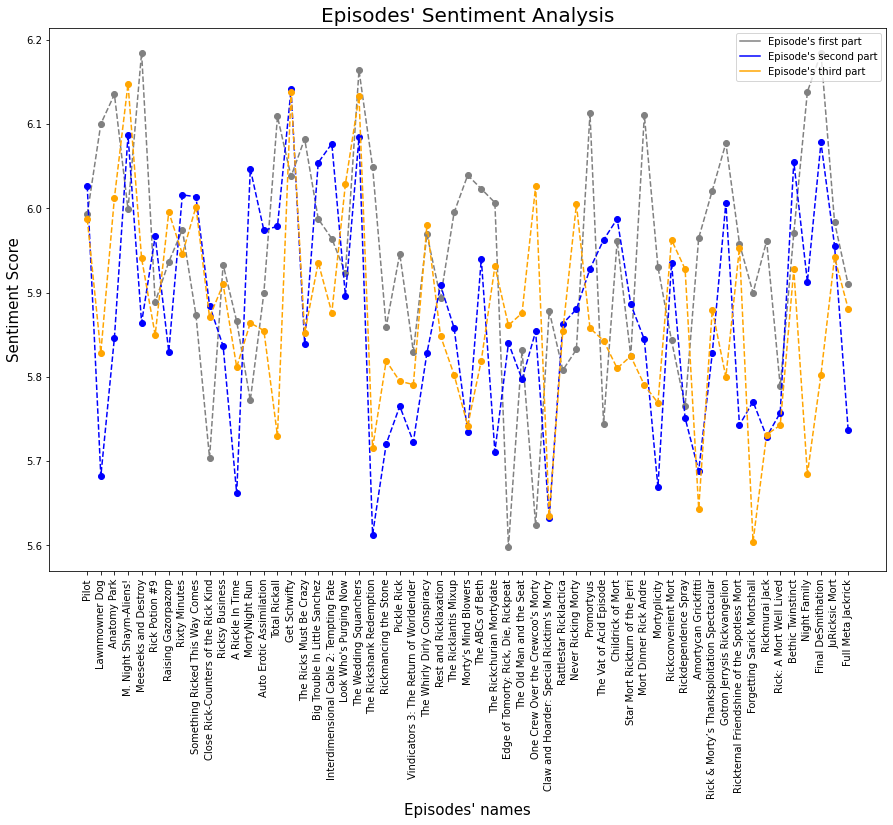

In [96]:
# plot 
fig, ax = plt.subplots(figsize = (15,10))
plt.plot(transcripts_df2['episode_name'], transcripts_df2['first_part_sentiment_score'],
         'o--', color='grey',label='first part')
plt.plot(transcripts_df2['episode_name'], transcripts_df2['second_part_sentiment_score'],
         'o--', color='blue',label='second part')
plt.plot(transcripts_df2['episode_name'], transcripts_df2['third_part_sentiment_score'],
         'o--', color='orange',label='third part')
legends = [Line2D([0], [0], marker=None, color="grey", label= "Episode's first part"),
          Line2D([0], [0], marker=None, color="blue", label= "Episode's second part"),
          Line2D([0], [0], marker=None, color="orange", label= "Episode's third part")]

# ax.axvline('Ricksy Business', color="k", linestyle = ":")
# ax.axvline('The Wedding Squanchers', color="k", linestyle = ":")
# ax.axvline('The Rickchurian Mortydate', color="k", linestyle = ":")
# ax.axvline('Star Mort Rickturn of the Jerri', color="k", linestyle = ":")
# ax.axvline('Rickmurai Jack', color="k", linestyle = ":")
ax.set_xlabel("Episodes' names", size = 15)
ax.set_ylabel("Sentiment Score", size = 15)
plt.xticks(rotation=90)
plt.legend(handles = legends, loc=1, fontsize = 10)
plt.title("Episodes' Sentiment Analysis", size=20)
#plt.legend(handles = legends, loc=1, fontsize = 10)
plt.show()


## Relation between sentiment and imdb rating

In this section we are going to use the ratings that we scrapped from imdb for each episode in order to check if there is a correlation between the sentiment score and the imdb rating.

In [97]:
ratings_df = pd.read_csv("../Data/ratings.csv")
ratings_df['lower_name'] = ratings_df['movie_title'].str.lower()
transcripts_df['lower_name'] = transcripts_df['episode_name'].str.lower()

In [98]:
merged = transcripts_df.merge(ratings_df[['lower_name','movie_title', 'rating']], left_on = 'lower_name', right_on='lower_name', how='inner')
merged = merged.drop(['movie_title', 'lower_name'], axis=1)
merged = merged[merged['rating']>0]

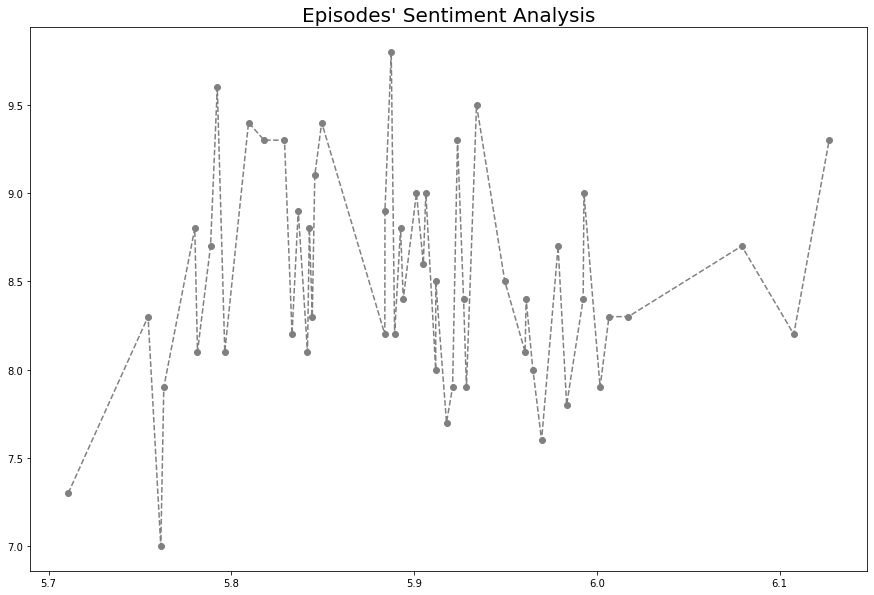

 corr = 0.03431754455582813


In [99]:
 # plot 
merged.sort_values('sentiment_score', ascending=True, inplace=True)
fig, ax = plt.subplots(figsize = (15,10))
plt.plot(merged['sentiment_score'], merged['rating'],
         'o--', color='grey',label='first part')
#plt.legend(handles = legends, loc=1, fontsize = 10)
plt.title("Episodes' Sentiment Analysis", size=20)
#plt.legend(handles = legends, loc=1, fontsize = 10)
plt.show()

print(f" corr = {merged['rating'].corr(merged['sentiment_score'], method='pearson')}")

From the plot above betwwen the sentiment score and the imdb rating we cannot see any correlation. 
Furthermore we computed the perason correlation coefficient between these two varaibles and from the result our intuition seems to be proved.

## Sentiment Analysis Using NRC


LabMT word list as described above was created to analyze tweets. A series (or movie) plot is a piece of text a lot different than a tweet. Therefore we wanted to use a more robust tool to do our sentiment analysis. Therefore we picked the NRC sentiment analysis library.

In [102]:
from nrclex import NRCLex

def calculate_nrc_sentiment(tokens_list):
    #print(NRCLex(tokens_list).raw_emotion_scores)
    return NRCLex(tokens_list).raw_emotion_scores

def clean_and_lemmatize(x):
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    lemmatizer = nltk.WordNetLemmatizer()
    
    tokens = tokenizer.tokenize(x)
    lemmatized_tokens = [ lemmatizer.lemmatize(token) for token in tokens]
    lemmatized_tokens = " ".join(lemmatized_tokens)
    return lemmatized_tokens



In [103]:
transcripts_df = pd.read_csv("../Data/transcripts.csv")
transcripts_df['transcript'] = transcripts_df['transcript'].str.lower()
transcripts_df['transcript'] = transcripts_df['transcript'].apply(clean_and_lemmatize)
transcripts_df.head()

Unnamed: 0  season  episode_num            episode_name  \
0           0       1            1                   Pilot   
1           1       1            2          Lawnmowner Dog   
2           2       1            3            Anatomy Park   
3           3       1            4  M. Night Shaym-Aliens!   
4           4       1            5    Meeseeks and Destroy   

                                          transcript  
0  morty you got to come on you got to come with ...  
1  coin collecting is considered the perfect hobb...  
2  mmm jerry you are really giving it to this ham...  
3  rick t t t this is just sloppy craftsmanship m...  
4  run morty do it hit the button now i can t do ...

In [104]:
nrc_sents_scores = transcripts_df['transcript'].apply(calculate_nrc_sentiment)

nrc_sents_dict = {'joy':[],'trust':[],'anticipation':[],'fear':[],'anger':[],'disgust':[],
             'sadness':[],'surprise':[],'positive':[],'negative':[]}

for sent,associated_list in nrc_sents_dict.items():
    for score in nrc_sents_scores:
        associated_list.append(score[sent])
    transcripts_df[sent] = associated_list


transcripts_df.head()

Unnamed: 0  season  episode_num            episode_name  \
0           0       1            1                   Pilot   
1           1       1            2          Lawnmowner Dog   
2           2       1            3            Anatomy Park   
3           3       1            4  M. Night Shaym-Aliens!   
4           4       1            5    Meeseeks and Destroy   

                                          transcript  joy  trust  \
0  morty you got to come on you got to come with ...   85    137   
1  coin collecting is considered the perfect hobb...   56    103   
2  mmm jerry you are really giving it to this ham...   81     94   
3  rick t t t this is just sloppy craftsmanship m...   86    127   
4  run morty do it hit the button now i can t do ...   78    110   

   anticipation  fear  anger  disgust  sadness  surprise  positive  negative  
0            77    76     66       52       66        46       182       128  
1            72    89     56       65       60        29       148       126  
2            86    74     53       48       59        27       150       114  
3            95    47     23       34       38        63       160        92  
4           106    83     59       42       70        37       175       138

## Sentiment throughout the episode


In [105]:
transcripts_df['first_part'] = transcripts_df['transcript'].apply(lambda x: split_into_3(x,1))
transcripts_df['second_part'] = transcripts_df['transcript'].apply(lambda x: split_into_3(x,2))
transcripts_df['third_part'] = transcripts_df['transcript'].apply(lambda x: split_into_3(x,3))

In [106]:
parts = ['first_part', 'second_part', 'third_part']

for part in parts:
    nrc_sents_scores = transcripts_df[part].apply(calculate_nrc_sentiment)

    nrc_sents_dict = {'joy':[],'trust':[],'anticipation':[],'fear':[],'anger':[],'disgust':[],
                 'sadness':[],'surprise':[],'positive':[],'negative':[]}

    for sent,associated_list in nrc_sents_dict.items():
        for score in nrc_sents_scores:
            associated_list.append(score[sent])
        transcripts_df[part+'_'+sent] = associated_list

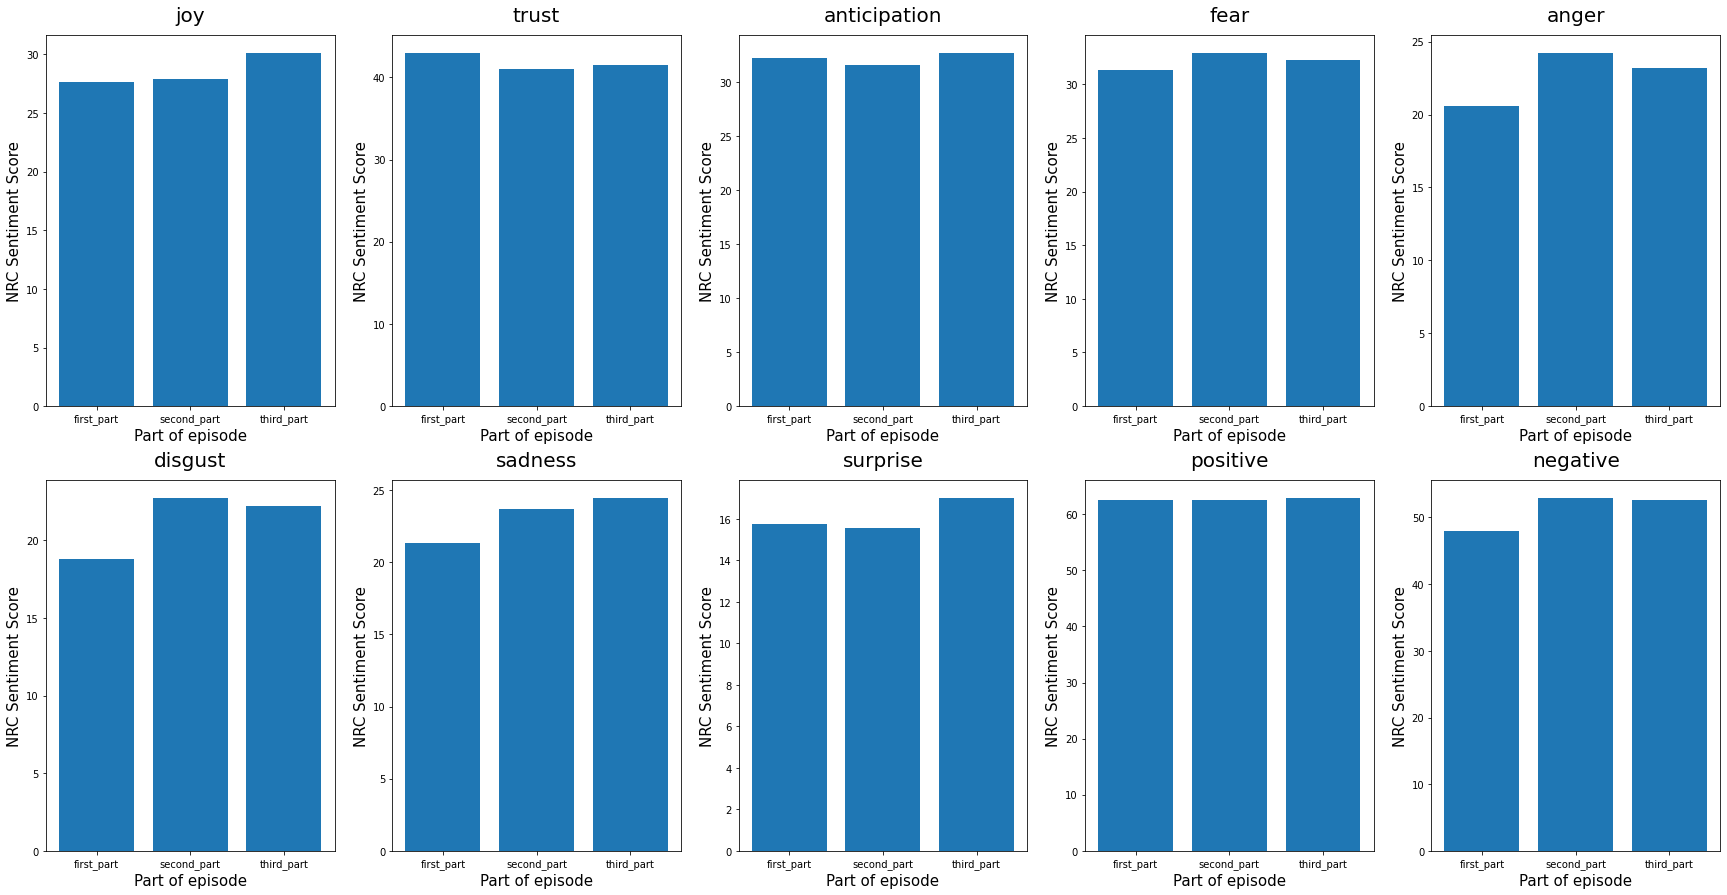

In [107]:
fig, axs = plt.subplots(nrows=2, ncols = 5, figsize = (30, 15))
s=0
for i in range(2):
    for j in range(5):
        sent = list(nrc_sents_dict.keys())[s]
        scores = [transcripts_df[part+'_'+sent].mean() for part in parts]
        
        axs[i, j].bar(parts,scores)
        axs[i, j].set_title(sent, fontsize = 20, pad=14)
        axs[i, j].set_xlabel("Part of episode", size = 15)
        axs[i, j].set_ylabel("NRC Sentiment Score", size = 15)
        s+=1
plt.show()

Here we analyzed again h

## Relation between sentiment and imdb rating


In [108]:
ratings_df = pd.read_csv("../Data/ratings.csv")
ratings_df['lower_name'] = ratings_df['movie_title'].str.lower()
transcripts_df['lower_name'] = transcripts_df['episode_name'].str.lower()

merged = transcripts_df.merge(ratings_df[['lower_name','movie_title', 'rating']], left_on = 'lower_name', right_on='lower_name', how='inner')
merged = merged.drop(['movie_title', 'lower_name'], axis=1)
merged = merged[merged['rating']>0]

In [109]:
correlations = []
for sent in nrc_sents_dict.keys():

    correlations.append(merged['rating'].corr(merged[sent], method='pearson'))
    print(f"{sent} corr = {merged['rating'].corr(merged[sent], method='pearson')}")

joy corr = -0.07523347312599472
trust corr = -0.018898693282560986
anticipation corr = -0.046773531366067184
fear corr = -0.051711440673278736
anger corr = -0.18235867775979742
disgust corr = -0.16674113837740356
sadness corr = -0.13590303053601346
surprise corr = 0.13803345037848302
positive corr = -0.07574202479738068
negative corr = -0.004904496614212924


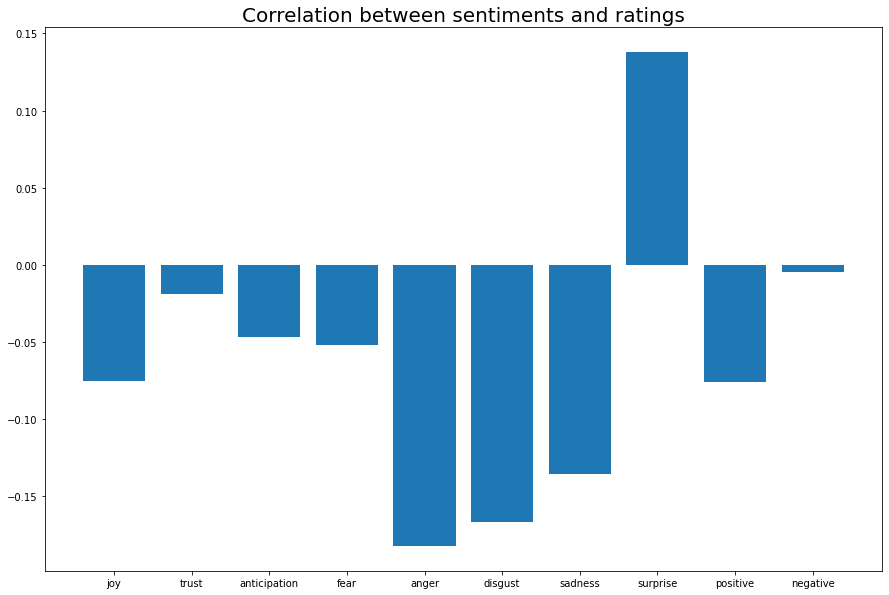

In [110]:
# plot 

fig, ax = plt.subplots(figsize = (15,10))
plt.bar(nrc_sents_dict.keys(), correlations)
plt.title("Correlation between sentiments and ratings", size=20)
plt.show()

Our first observation here is that none of the sentiments from NRC list has a very strong correlation to the imdb ratings. Nevertheless, it is clear that sentiments such as anger, disgust, and sadness have a negative correlation with the imdb ratings. Another insteresting finding is that the only sentiment that has positive correlation with the imdb rating is the surprise sentiment.